In [217]:
import astropy
import future
import nolds
import numpy
import pandas as pd
import numpy as np
import datetime
import hrvanalysis
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features, get_frequency_domain_features, get_time_domain_features, get_geometrical_features, get_csi_cvi_features, get_poincare_plot_features
from hrvanalysis.plot import VlfBand, LfBand, HfBand

print(dir(hrvanalysis))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'extract_features', 'get_csi_cvi_features', 'get_frequency_domain_features', 'get_geometrical_features', 'get_nn_intervals', 'get_poincare_plot_features', 'get_sampen', 'get_time_domain_features', 'interpolate_nan_values', 'plot', 'plot_distrib', 'plot_poincare', 'plot_psd', 'plot_timeseries', 'preprocessing', 'remove_ectopic_beats', 'remove_outliers']


In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('signal_data.csv')

# Store each column as a list
timestamp = df['Timestamp'].tolist()
rr = df['RR-intervals'].tolist()
print("first", rr[:5])
rr = [float(i) for i in rr]
print("first", rr[:5])
raw_rr_data_combined = np.array(rr)
# Remove outliers from signal
rr_intervals_without_outliers = remove_outliers(rr_intervals=raw_rr_data_combined,low_rri=300, high_rri=2000)
# Replaces outliers nan values with linear interpolation
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,interpolation_method="linear")
# Remove ectopic beats from signal
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")

# Replace ectopic beats nan values with linear interpolation
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
rr_data_cleaned = interpolated_nn_intervals

# Calculate the average RR interval time
mean_rr_time = np.mean(rr_data_cleaned)
print("Average interval time: ", mean_rr_time)

# Estimate the sample rate
sample_rate_estimate = 1 / (mean_rr_time/1000)

print("Estimated sample rate:", sample_rate_estimate, "Hz")

# Set a starting time
start_time = datetime.datetime(2024, 2, 7, 6, 54, 32)

# Extract last millisecond from the starting time
last_millisecond = start_time.microsecond

# Create a copy of the cleaned RR data
cleaned_rr_data_modified = rr_data_cleaned.copy()

# Adjust the first RR interval by adding the last millisecond from the starting time
cleaned_rr_data_modified[0] += last_millisecond

# Calculate cumulative sum of RR-intervals
cumulative_sum = np.cumsum(cleaned_rr_data_modified)

# Create timestamps
timestamps = [start_time + datetime.timedelta(milliseconds=ms) for ms in cumulative_sum]

# Create DataFrame directly from timestamps
df_time = pd.DataFrame({"Timestamp": timestamps})

# Convert timestamps to Unix timestamps (numerical values)
timestamps_unix = [ts.timestamp() for ts in timestamps]

# Create DataFrame with timestamps and signal values
df = pd.DataFrame({'Timestamp': timestamps_unix, 'RR-intervals': rr_data_cleaned})

def sliding_window_analysis(signal, timestamps, window_length, overlap_percentage):
    results = []
    overlap = int(window_length * (overlap_percentage / 100))
    vlf_band = VlfBand(low=0.003, high=0.04)
    lf_band = LfBand(low=0.04, high=0.15)
    hf_band = HfBand(low=0.15, high=0.4)
    for i in range(0, len(signal) - window_length + 1, overlap):
        window = signal[i:i + window_length]
        window_timestamps_ = timestamps[i:i + window_length]
        window_mean = np.mean(window)
        window_center_time = np.mean(window_timestamps_)
        # window_features = get_frequency_domain_features(window)
        window_features = get_frequency_domain_features(window, vlf_band=vlf_band, lf_band=lf_band, hf_band=hf_band)
        time_d_features = get_time_domain_features(window)
        nonlin_features = get_csi_cvi_features(window)
        nonlin_poincare_features = get_poincare_plot_features(window)
        results.append((window_center_time, window_mean, window_features, time_d_features, nonlin_features, nonlin_poincare_features))
    return results

# Set the window length and overlap percentage
window_length = 100  
overlap_percentage = 90  

# Perform sliding window analysis
window_results = sliding_window_analysis(df['RR-intervals'].values, df['Timestamp'].values, window_length, overlap_percentage)

# Unzip the results to get timestamps and filtered signal
window_center_time, full_signal_with_time, freq_d_features, time_d_features, nonlin_features, poincare_features = zip(*window_results)

# Extract all frequency-domain features

linear_feature_names = list(time_d_features[0].keys())
freq_feature_names = list(freq_d_features[0].keys())
nonlin_feature_names = list(nonlin_features[0].keys())
poincare_feature_names = list(poincare_features[0].keys())

data = {"window_center_time": window_center_time, "full_signal_with_time": full_signal_with_time,
        "freq_d_features": freq_d_features, "time_d_features": time_d_features,
        "poincare_features": poincare_features,
        "nonlin_features": nonlin_features}

first [704.0, 720.0, 696.0, 712.0, 728.0]
first [704.0, 720.0, 696.0, 712.0, 728.0]
0 outlier(s) have been deleted.
174 ectopic beat(s) have been deleted with malik rule.
Average interval time:  811.8059575525416
Estimated sample rate: 1.2318214601612827 Hz


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 252, using nperseg = 252
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 243, using nperseg = 243
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 205, using nperseg = 205
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 254, using nperseg = 254
  warnings.warn('nperseg = {0:d} is greater than inp

In [ ]:
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


#with open('hrv_data_5.json', 'w') as json_file:
 #   json.dump(data, json_file)
transformed_data = []
for elem in window_results:
    transformed_data.append({
    'window_start': elem[0],
    'mean_rr': elem[1],
    'frequency': elem[2],
    'time_data': elem[3],
    'nonlinear': elem[4],
    'poincare': elem[5]})

json_string = json.dumps(transformed_data, cls=NpEncoder)

# write the JSON string to a file 
#with open('feature_data.json', 'w') as json_file:
 #   json_file.write(json_string)

In [ ]:
# Proceed with dataframe df
print(df.shape)
# Check the element count
element_count = len(rr)

# Print the element count
print("Element count:", element_count)

(107509, 2)
Element count: 107509


In [ ]:
# Define the desired window length in seconds (15 minutes)
desired_window_length_minutes = 16.8
desired_window_length_seconds = desired_window_length_minutes * 60  # Convert minutes to seconds

# Calculate the number of data points equivalent to the desired window length
num_data_points_in_15_minutes = int(sample_rate_estimate * desired_window_length_seconds)

# Use this value as the window length for sliding window analysis
window_length_2 = num_data_points_in_15_minutes


# Perform sliding window analysis
results = sliding_window_analysis(df['RR-intervals'].values, df['Timestamp'].values, window_length_2, overlap_percentage)

# Unzip the results to get timestamps and filtered signal
window_center_time, full_signal_with_time, freq_d_features, time_d_features, nonlin_features, poincare_features = zip(*results)

result_dict = {"window_center_time": window_center_time, "full_signal_with_time": full_signal_with_time,
        "freq_d_features": freq_d_features, "time_d_features": time_d_features,
        "poincare_features": poincare_features,
        "nonlin_features": nonlin_features}

In [ ]:
# Initialize empty dictionary to collect feature values for all features
all_feature_values = {key: [] for key in result_dict['freq_d_features'][0]}
all_feature_values.update({key: [] for key in result_dict['time_d_features'][0]})
all_feature_values.update({key: [] for key in result_dict['poincare_features'][0]})
all_feature_values.update({key: [] for key in result_dict['nonlin_features'][0]})

# Collect feature values from freq_d_features
for entry in result_dict['freq_d_features']:
    for key, value in entry.items():
        all_feature_values[key].append(value)

# Collect feature values from time_d_features
for entry in result_dict['time_d_features']:
    for key, value in entry.items():
        all_feature_values[key].append(value)

# Collect feature values from poincare_features
for entry in result_dict['poincare_features']:
    for key, value in entry.items():
        all_feature_values[key].append(value)

# Collect feature values from nonlin_features
for entry in result_dict['nonlin_features']:
    for key, value in entry.items():
        all_feature_values[key].append(value)

# Create DataFrame from all feature values
all_features_df = pd.DataFrame(all_feature_values)

# Display DataFrame
display(all_features_df)

# Save to a CSV file
all_features_df.to_csv('all_features.csv', index=False)


lf           hf  lf_hf_ratio       lfnu       hfnu   total_power  \
0   1277.566181   244.036472     5.235144  83.961879  16.038121   2398.804572   
1   1461.552184   512.975815     2.849164  74.020332  25.979668   2622.433682   
2    958.935867   270.538657     3.544543  77.995587  22.004413   1532.004169   
3   1832.665532   309.649812     5.918510  85.546021  14.453979   3074.615127   
4   2266.779688   377.892244     5.998482  85.711186  14.288814   3364.328076   
5   1401.241412   314.928444     4.449396  81.649343  18.350657   2676.366160   
6   2066.478666   271.208385     7.619524  88.398431  11.601569   3031.058968   
7   1939.602957   582.400131     3.330361  76.907240  23.092760   3395.051753   
8   1909.592909   658.852342     2.898362  74.348204  25.651796   3398.571590   
9   1781.721245   469.111253     3.798078  79.158322  20.841678   4173.554044   
10  1950.941098   313.137886     6.230294  86.169304  13.830696   3286.544002   
11  3043.831050   636.043687     4.785569  82.715616  17.284384   5146.216754   
12  4625.476354   535.801741     8.632813  89.618817  10.381183   6670.325369   
13  4461.741243   655.936398     6.802094  87.182929  12.817071   6655.023216   
14  3220.109266   390.897680     8.237729  89.174829  10.825171   4772.985606   
15  2855.215695   457.284920     6.243844  86.195175  13.804825   4900.712106   
16  1331.789521   266.723045     4.993155  83.314298  16.685702   2297.233055   
17  1840.471433   612.608593     3.004319  75.026963  24.973037   3304.986947   
18  2966.520121   793.723570     3.737473  78.891699  21.108301   4563.278751   
19  2707.701769   656.700320     4.123192  80.480920  19.519080   4070.777527   
20  2447.357866   494.050343     4.953661  83.203612  16.796388   3790.036393   
21  2897.809706   470.103628     6.164193  86.041695  13.958305   3992.057386   
22  2544.372519   421.285893     6.039539  85.794524  14.205476   3765.287235   
23   994.455699   174.298740     5.705467  85.086795  14.913205   1864.834020   
24  1118.733640   201.445122     5.553540  84.741072  15.258928   2035.594820   
25  1118.111867   270.372746     4.135446  80.527494  19.472506   2289.424215   
26  1431.746253   452.073089     3.167068  76.002312  23.997688   2860.561953   
27  1470.116989   333.827556     4.403822  81.494578  18.505422   2152.240164   
28  1207.538406   216.289415     5.582975  84.809300  15.190700   1906.629576   
29  1181.939745   265.214036     4.456551  81.673403  18.326597   2213.390453   
30  2436.071863   386.437158     6.303928  86.308736  13.691264   3414.014546   
31  1902.216032   280.131750     6.790434  87.163744  12.836256   3121.240274   
32  1705.791437   289.233506     5.897627  85.502261  14.497739   3089.327000   
33   835.848587   207.222002     4.033590  80.133463  19.866537   1528.132957   
34  1713.603830   282.951607     6.056173  85.828011  14.171989   3084.735171   
35  1902.460093   370.604170     5.133402  83.695834  16.304166   3015.181811   
36  1369.678219   175.184823     7.818475  88.660171  11.339829   2115.794742   
37   829.957483   220.153713     3.769900  79.035200  20.964800   1563.066246   
38  1601.829406   333.276125     4.806313  82.777367  17.222633   2406.019066   
39  2074.490679   401.910397     5.161575  83.770384  16.229616   3243.590870   
40  1266.493708   269.431022     4.700623  82.458058  17.541942   2409.630012   
41   966.536754   262.124403     3.687321  78.665851  21.334149   2116.571604   
42   845.515681   209.904750     4.028092  80.111741  19.888259   1546.207568   
43  1364.541511   243.032128     5.614655  84.882053  15.117947   2618.887151   
44  2035.864272   398.815994     5.104771  83.619369  16.380631   3011.594905   
45  2798.378413   370.470789     7.553574  88.308980  11.691020   3835.821689   
46  2335.426569   377.969499     6.178876  86.070242  13.929758   3862.976348   
47  2163.299308   361.081083     5.991173  85.696249  14.303751   3862.213420   
48  2208.063142   296.715396     7.441687  8

In [ ]:
# Import self-reported stress data from Excel
file_path = r'C:\Users\Dominik\Documents\PPKE ITK\Sport Lab\stress_feedback.xlsx'

# Read the Excel file
feedback_df = pd.read_excel(file_path)

# Select the third column for positive stress and the fifth column for negative stress
positive_stress_values = feedback_df.iloc[:, 2]
negative_stress_values = feedback_df.iloc[:, 4]

# Create DataFrames with the stress values
pos_stress_df = pd.DataFrame({'Positive stress': positive_stress_values})
neg_stress_df = pd.DataFrame({'Negative stress': negative_stress_values})

# Define a function to reclassify stress levels
def classify_stress(value):
    if value == 0:
        return 0  # No stress or low stress
    else:
        return 1  # High stress

# Apply the function to reclassify stress levels
pos_stress_df['Positive Binary'] = pos_stress_df['Positive stress'].apply(classify_stress)
neg_stress_df['Negative Binary'] = neg_stress_df['Negative stress'].apply(classify_stress)

# Combine the positive and negative stress DataFrames
final_df = pd.concat([pos_stress_df, neg_stress_df], axis=1)

# Read the time column (assuming it's the first column)
time = feedback_df.iloc[:, 0]
final_df['Timestamp'] = pd.to_datetime(time)

# Sort the DataFrame by timestamp
final_df = final_df.sort_values(by='Timestamp')

# Find the last timestamp and the time interval between the last two timestamps
before_gap_timestamp = final_df.iloc[57]['Timestamp']
after_gap_timestamp = final_df.iloc[58]['Timestamp']

# Generate a sequence of timestamps at 15-minute intervals from the last timestamp
time_interval = pd.Timedelta(minutes=15)
new_timestamps = pd.date_range(start=before_gap_timestamp + time_interval, end=after_gap_timestamp, freq='15T')

# Create a DataFrame with the new timestamps
new_df = pd.DataFrame({'Timestamp': new_timestamps})

# Concatenate the original DataFrame and the new DataFrame
final_df = pd.concat([final_df, new_df])

# Sort the DataFrame by timestamp
final_df = final_df.sort_values(by='Timestamp')

# Reset the index
final_df = final_df.reset_index(drop=True)

# Drop the first row
final_df = final_df.drop(final_df.index[0])

# Fill NaN values with 0
final_df.fillna(0, inplace=True)

# Display the final DataFrame
pd.set_option('display.max_rows', None)
display(final_df)



C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\3866825384.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_timestamps = pd.date_range(start=before_gap_timestamp + time_interval, end=after_gap_timestamp, freq='15T')


Positive stress  Positive Binary  Negative stress  Negative Binary  \
1               1.0              1.0              1.0              1.0   
2               2.0              1.0              0.0              0.0   
3               2.0              1.0              0.0              0.0   
4               3.0              1.0              0.0              0.0   
5               1.0              1.0              1.0              1.0   
6               0.0              0.0              0.0              0.0   
7               0.0              0.0              0.0              0.0   
8               1.0              1.0              0.0              0.0   
9               0.0              0.0              0.0              0.0   
10              1.0              1.0              0.0              0.0   
11              1.0              1.0              0.0              0.0   
12              1.0              1.0              0.0              0.0   
13              1.0              1.0              0.0              0.0   
14              1.0              1.0              0.0              0.0   
15              1.0              1.0              0.0              0.0   
16              1.0              1.0              0.0              0.0   
17              0.0              0.0              1.0              1.0   
18              1.0              1.0              0.0              0.0   
19              0.0              0.0              1.0              1.0   
20              2.0              1.0              0.0              0.0   
21              2.0              1.0              0.0              0.0   
22              2.0              1.0              0.0              0.0   
23              2.0              1.0              0.0              0.0   
24              2.0              1.0              0.0              0.0   
25              2.0              1.0              0.0              0.0   
26              2.0              1.0              0.0              0.0   
27              2.0              1.0              1.0              1.0   
28              3.0              1.0              0.0              0.0   
29              3.0              1.0              0.0              0.0   
30              3.0              1.0              0.0              0.0   
31              2.0              1.0              0.0              0.0   
32              0.0              0.0              0.0              0.0   
33              1.0              1.0              0.0              0.0   
34              0.0              0.0              0.0              0.0   
35              2.0              1.0              0.0              0.0   
36              2.0              1.0              0.0              0.0   
37              0.0              0.0              0.0              0.0   
38              0.0              0.0              0.0              0.0   
39              0.0              0.0              0.0              0.0   
40              1.0              1.0              0.0              0.0   
41              2.0              1.0              0.0              0.0   
42              1.0              1.0              0.0              0.0   
43              1.0              1.0              0.0              0.0   
44              1.0              1.0              0.0              0.0   
45              1.0              1.0              0.0              0.0   
46              2.0              1.0              0.0              0.0   
47              0.0              0.0              0.0              0.0   
48              2.0              1.0              0.0              0.0   
49              2.0              1.0              0.0              0.0   
50              2.0              1.0              0.0              0.0   
51              2.0              1.0              0.0              0.0   
52              1.0              1.0              1.0              1.0   
53              1.0              1.0              0.0              0.0   
54      

In [224]:
# Creating Multiclass Labels
def classify_stress(value):
    if value == 0:
        return 'No Stress'
    elif 0 < value <= 2:
        return 'Low Stress'
    elif value > 2:
        return 'High Stress'

final_df['Positive Stress Category'] = final_df['Positive stress'].apply(classify_stress)
final_df['Negative Stress Category'] = final_df['Negative stress'].apply(classify_stress)

final_df['Total Stress'] = final_df['Positive stress'] + final_df['Negative stress']

In [225]:
final_df

Positive stress  Positive Binary  Negative stress  Negative Binary  \
1               1.0              1.0              1.0              1.0   
2               2.0              1.0              0.0              0.0   
3               2.0              1.0              0.0              0.0   
4               3.0              1.0              0.0              0.0   
5               1.0              1.0              1.0              1.0   
6               0.0              0.0              0.0              0.0   
7               0.0              0.0              0.0              0.0   
8               1.0              1.0              0.0              0.0   
9               0.0              0.0              0.0              0.0   
10              1.0              1.0              0.0              0.0   
11              1.0              1.0              0.0              0.0   
12              1.0              1.0              0.0              0.0   
13              1.0              1.0              0.0              0.0   
14              1.0              1.0              0.0              0.0   
15              1.0              1.0              0.0              0.0   
16              1.0              1.0              0.0              0.0   
17              0.0              0.0              1.0              1.0   
18              1.0              1.0              0.0              0.0   
19              0.0              0.0              1.0              1.0   
20              2.0              1.0              0.0              0.0   
21              2.0              1.0              0.0              0.0   
22              2.0              1.0              0.0              0.0   
23              2.0              1.0              0.0              0.0   
24              2.0              1.0              0.0              0.0   
25              2.0              1.0              0.0              0.0   
26              2.0              1.0              0.0              0.0   
27              2.0              1.0              1.0              1.0   
28              3.0              1.0              0.0              0.0   
29              3.0              1.0              0.0              0.0   
30              3.0              1.0              0.0              0.0   
31              2.0              1.0              0.0              0.0   
32              0.0              0.0              0.0              0.0   
33              1.0              1.0              0.0              0.0   
34              0.0              0.0              0.0              0.0   
35              2.0              1.0              0.0              0.0   
36              2.0              1.0              0.0              0.0   
37              0.0              0.0              0.0              0.0   
38              0.0              0.0              0.0              0.0   
39              0.0              0.0              0.0              0.0   
40              1.0              1.0              0.0              0.0   
41              2.0              1.0              0.0              0.0   
42              1.0              1.0              0.0              0.0   
43              1.0              1.0              0.0              0.0   
44              1.0              1.0              0.0              0.0   
45              1.0              1.0              0.0              0.0   
46              2.0              1.0              0.0              0.0   
47              0.0              0.0              0.0              0.0   
48              2.0              1.0              0.0              0.0   
49              2.0              1.0              0.0              0.0   
50              2.0              1.0              0.0              0.0   
51              2.0              1.0              0.0              0.0   
52              1.0              1.0              1.0              1.0   
53              1.0              1.0              0.0              0.0   
54      

In [226]:
# Save the final DataFrame to a CSV file
final_df.to_csv('perceived_stress_data.csv', index=False)

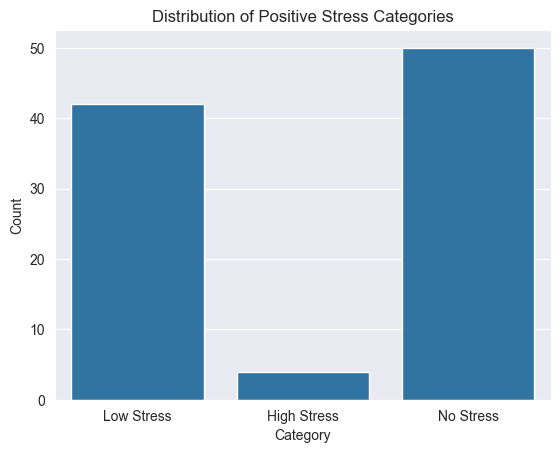

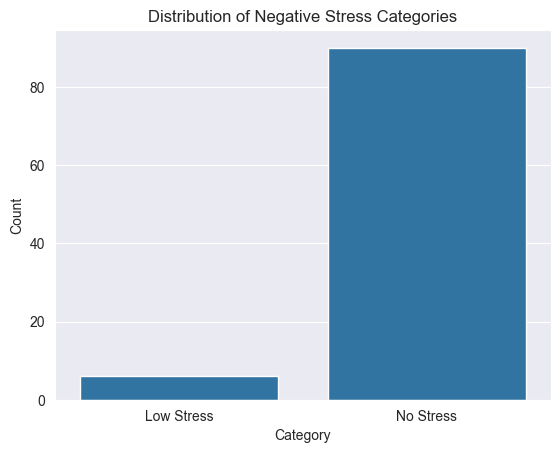

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Positive Stress Category
sns.countplot(x='Positive Stress Category', data=final_df)
plt.title('Distribution of Positive Stress Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Distribution of Negative Stress Category
sns.countplot(x='Negative Stress Category', data=final_df)
plt.title('Distribution of Negative Stress Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


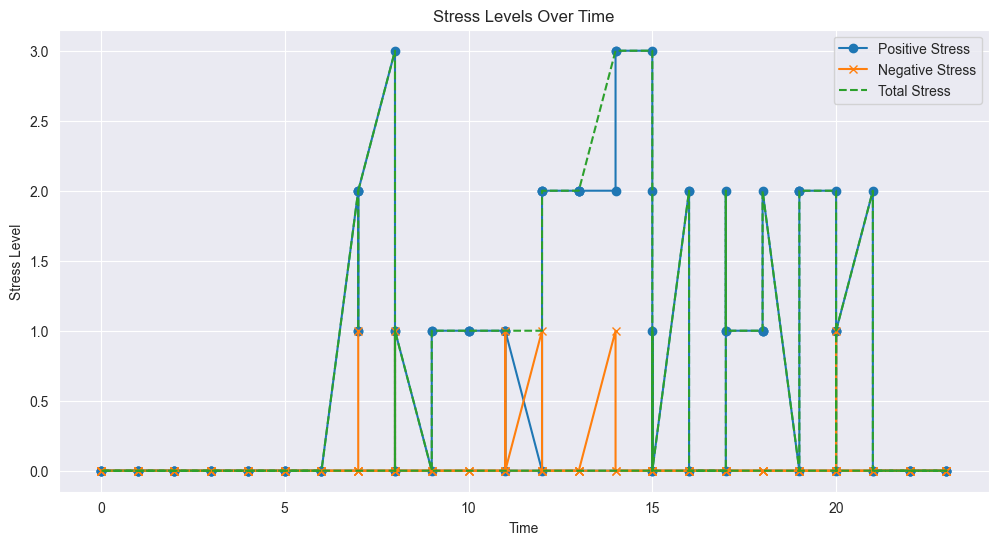

In [228]:
# Plot stress levels over time
# Extract hour from timestamp
final_df['Hour'] = final_df['Timestamp'].dt.hour
plt.figure(figsize=(12, 6))
plt.plot(final_df['Hour'], final_df['Positive stress'], label='Positive Stress', marker='o')
plt.plot(final_df['Hour'], final_df['Negative stress'], label='Negative Stress', marker='x')
plt.plot(final_df['Hour'], final_df['Total Stress'], label='Total Stress', linestyle='--')
plt.title('Stress Levels Over Time')
plt.xlabel('Time')
plt.ylabel('Stress Level')
plt.legend()
plt.show()

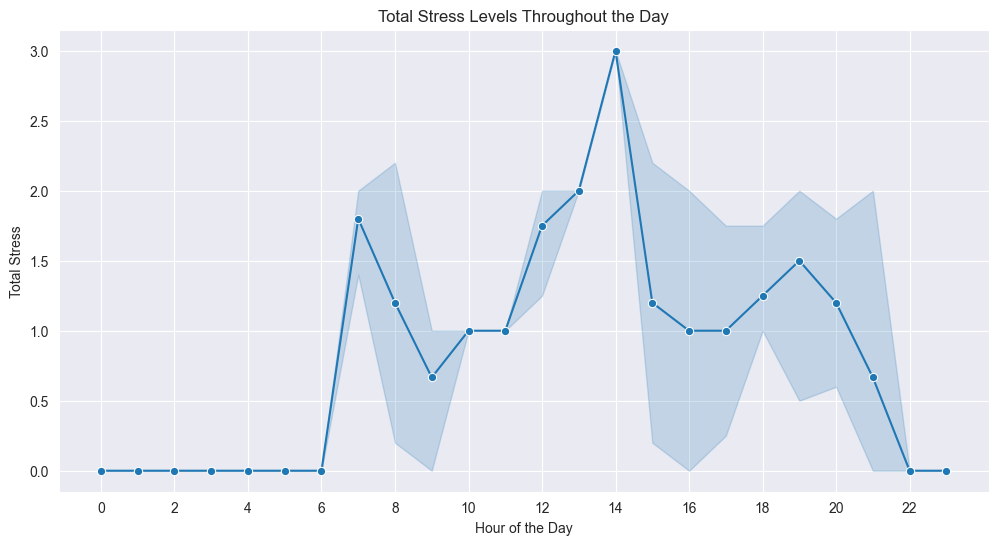

In [229]:
# Plot stress levels by hour
plt.figure(figsize=(12, 6))
sns.lineplot(x='Hour', y='Total Stress', data=final_df, marker='o')
plt.title('Total Stress Levels Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Stress')
plt.xticks(range(0, 24, 2))
plt.show()

In [230]:
# Ensure both datasets have the same number of rows
assert len(all_features_df) == len(final_df), "Datasets must have the same number of rows to merge."

# Concatenate the datasets along the columns
#merged_df = pd.concat([all_features_df, final_df], axis=1)
# Merge the datasets directly
merged_df = pd.concat([all_features_df.reset_index(drop=True), final_df.reset_index(drop=True)], axis=1)



In [231]:
merged_df

lf           hf  lf_hf_ratio       lfnu       hfnu   total_power  \
0   1277.566181   244.036472     5.235144  83.961879  16.038121   2398.804572   
1   1461.552184   512.975815     2.849164  74.020332  25.979668   2622.433682   
2    958.935867   270.538657     3.544543  77.995587  22.004413   1532.004169   
3   1832.665532   309.649812     5.918510  85.546021  14.453979   3074.615127   
4   2266.779688   377.892244     5.998482  85.711186  14.288814   3364.328076   
5   1401.241412   314.928444     4.449396  81.649343  18.350657   2676.366160   
6   2066.478666   271.208385     7.619524  88.398431  11.601569   3031.058968   
7   1939.602957   582.400131     3.330361  76.907240  23.092760   3395.051753   
8   1909.592909   658.852342     2.898362  74.348204  25.651796   3398.571590   
9   1781.721245   469.111253     3.798078  79.158322  20.841678   4173.554044   
10  1950.941098   313.137886     6.230294  86.169304  13.830696   3286.544002   
11  3043.831050   636.043687     4.785569  82.715616  17.284384   5146.216754   
12  4625.476354   535.801741     8.632813  89.618817  10.381183   6670.325369   
13  4461.741243   655.936398     6.802094  87.182929  12.817071   6655.023216   
14  3220.109266   390.897680     8.237729  89.174829  10.825171   4772.985606   
15  2855.215695   457.284920     6.243844  86.195175  13.804825   4900.712106   
16  1331.789521   266.723045     4.993155  83.314298  16.685702   2297.233055   
17  1840.471433   612.608593     3.004319  75.026963  24.973037   3304.986947   
18  2966.520121   793.723570     3.737473  78.891699  21.108301   4563.278751   
19  2707.701769   656.700320     4.123192  80.480920  19.519080   4070.777527   
20  2447.357866   494.050343     4.953661  83.203612  16.796388   3790.036393   
21  2897.809706   470.103628     6.164193  86.041695  13.958305   3992.057386   
22  2544.372519   421.285893     6.039539  85.794524  14.205476   3765.287235   
23   994.455699   174.298740     5.705467  85.086795  14.913205   1864.834020   
24  1118.733640   201.445122     5.553540  84.741072  15.258928   2035.594820   
25  1118.111867   270.372746     4.135446  80.527494  19.472506   2289.424215   
26  1431.746253   452.073089     3.167068  76.002312  23.997688   2860.561953   
27  1470.116989   333.827556     4.403822  81.494578  18.505422   2152.240164   
28  1207.538406   216.289415     5.582975  84.809300  15.190700   1906.629576   
29  1181.939745   265.214036     4.456551  81.673403  18.326597   2213.390453   
30  2436.071863   386.437158     6.303928  86.308736  13.691264   3414.014546   
31  1902.216032   280.131750     6.790434  87.163744  12.836256   3121.240274   
32  1705.791437   289.233506     5.897627  85.502261  14.497739   3089.327000   
33   835.848587   207.222002     4.033590  80.133463  19.866537   1528.132957   
34  1713.603830   282.951607     6.056173  85.828011  14.171989   3084.735171   
35  1902.460093   370.604170     5.133402  83.695834  16.304166   3015.181811   
36  1369.678219   175.184823     7.818475  88.660171  11.339829   2115.794742   
37   829.957483   220.153713     3.769900  79.035200  20.964800   1563.066246   
38  1601.829406   333.276125     4.806313  82.777367  17.222633   2406.019066   
39  2074.490679   401.910397     5.161575  83.770384  16.229616   3243.590870   
40  1266.493708   269.431022     4.700623  82.458058  17.541942   2409.630012   
41   966.536754   262.124403     3.687321  78.665851  21.334149   2116.571604   
42   845.515681   209.904750     4.028092  80.111741  19.888259   1546.207568   
43  1364.541511   243.032128     5.614655  84.882053  15.117947   2618.887151   
44  2035.864272   398.815994     5.104771  83.619369  16.380631   3011.594905   
45  2798.378413   370.470789     7.553574  88.308980  11.691020   3835.821689   
46  2335.426569   377.969499     6.178876  86.070242  13.929758   3862.976348   
47  2163.299308   361.081083     5.991173  85.696249  14.303751   3862.213420   
48  2208.063142   296.715396     7.441687  8

In [232]:
# Display all column names
print(merged_df.columns.tolist())


['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf', 'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'sd1', 'sd2', 'ratio_sd2_sd1', 'csi', 'cvi', 'Modified_csi', 'Positive stress', 'Positive Binary', 'Negative stress', 'Negative Binary', 'Timestamp', 'Positive Stress Category', 'Negative Stress Category', 'Total Stress', 'Hour']


In [233]:
print(merged_df.isna().sum())

lf                          0
hf                          0
lf_hf_ratio                 0
lfnu                        0
hfnu                        0
total_power                 0
vlf                         0
mean_nni                    0
sdnn                        0
sdsd                        0
nni_50                      0
pnni_50                     0
nni_20                      0
pnni_20                     0
rmssd                       0
median_nni                  0
range_nni                   0
cvsd                        0
cvnni                       0
mean_hr                     0
max_hr                      0
min_hr                      0
std_hr                      0
sd1                         0
sd2                         0
ratio_sd2_sd1               0
csi                         0
cvi                         0
Modified_csi                0
Positive stress             0
Positive Binary             0
Negative stress             0
Negative Binary             0
Timestamp 

In [234]:
print(merged_df.describe())

                lf           hf  lf_hf_ratio       lfnu       hfnu  \
count    96.000000    96.000000    96.000000  96.000000  96.000000   
mean   1823.288386   466.630937     4.424572  79.627539  20.372461   
min     454.410425   174.298740     1.374705  57.889504  10.381183   
25%    1210.070608   283.589227     3.154856  75.931147  15.185578   
50%    1604.916886   385.561860     4.316023  81.183812  18.816188   
75%    2043.517871   493.999966     5.585198  84.814422  24.068853   
max    8791.868981  4741.235619     8.632813  89.618817  42.110496   
std    1161.283583   512.751428     1.656968   6.869189   6.869189   

        total_power          vlf     mean_nni        sdnn        sdsd  ...  \
count     96.000000    96.000000    96.000000   96.000000   96.000000  ...   
mean    3586.567600  1296.648277   811.686605   81.550835   36.931718  ...   
min     1299.424503   302.529644   634.149879   43.962466   20.292614  ...   
25%     2373.411693   718.596123   714.450443   63.649573

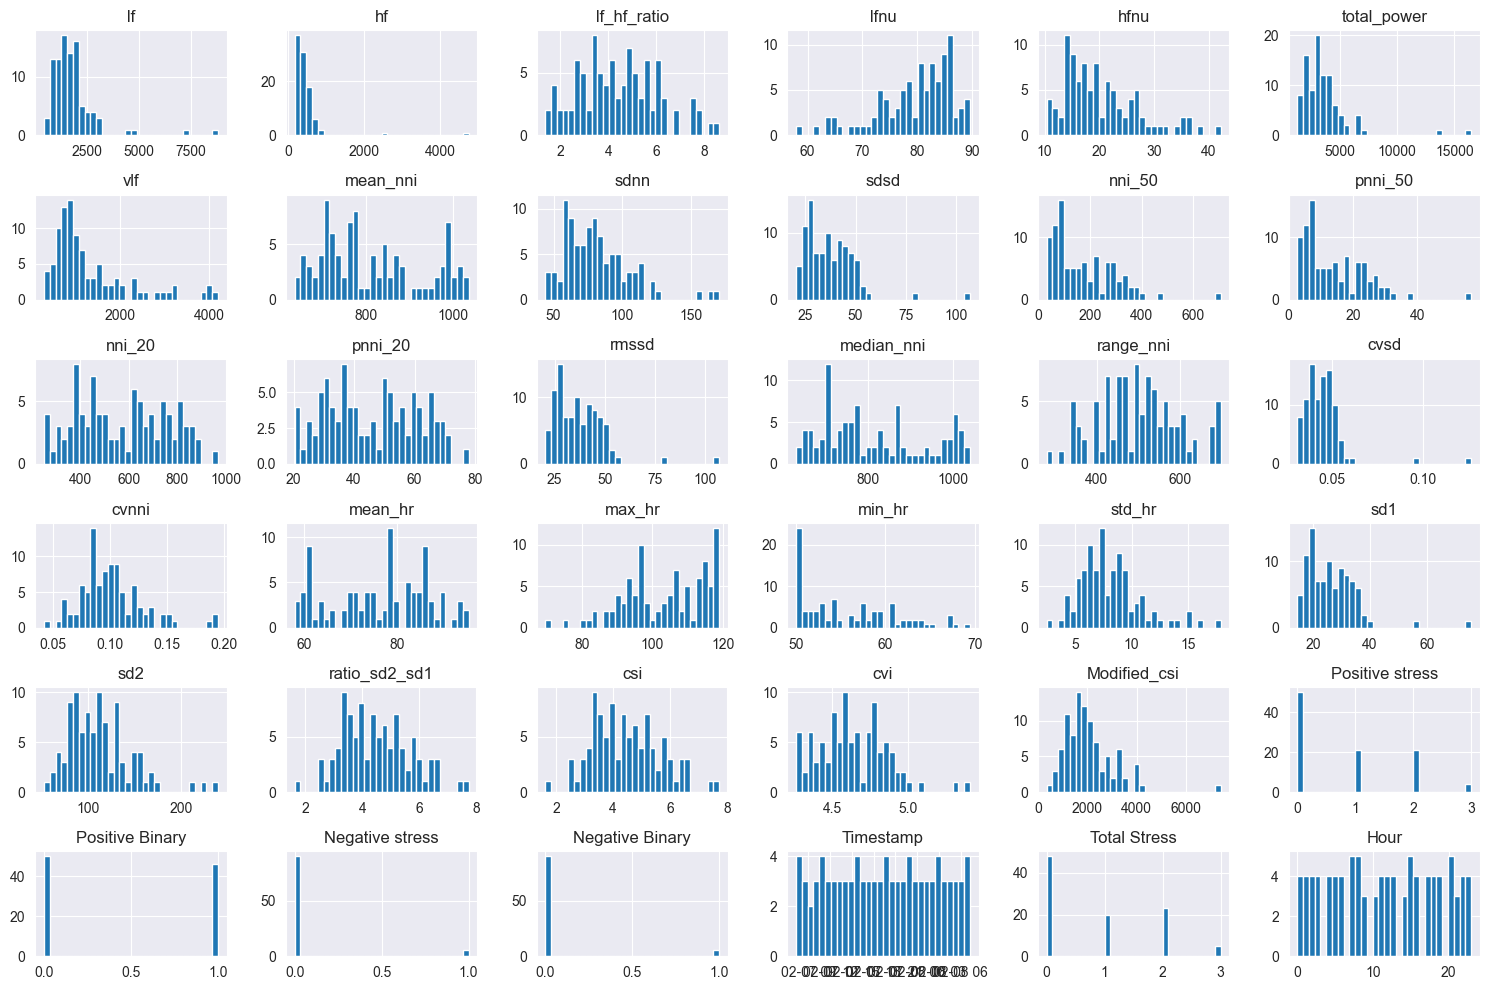

In [235]:
merged_df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

In [236]:
# Add dummies for 'Positive Stress Category' and 'Negative Stress Category' as new columns
positive_stress_dummies = pd.get_dummies(merged_df['Positive Stress Category'], prefix='Positive_Stress', drop_first=True)
negative_stress_dummies = pd.get_dummies(merged_df['Negative Stress Category'], prefix='Negative_Stress', drop_first=True)

# Concatenate the dummies with the original dataframe
merged_df = pd.concat([merged_df, positive_stress_dummies, negative_stress_dummies], axis=1)


In [237]:
merged_df

lf           hf  lf_hf_ratio       lfnu       hfnu   total_power  \
0   1277.566181   244.036472     5.235144  83.961879  16.038121   2398.804572   
1   1461.552184   512.975815     2.849164  74.020332  25.979668   2622.433682   
2    958.935867   270.538657     3.544543  77.995587  22.004413   1532.004169   
3   1832.665532   309.649812     5.918510  85.546021  14.453979   3074.615127   
4   2266.779688   377.892244     5.998482  85.711186  14.288814   3364.328076   
5   1401.241412   314.928444     4.449396  81.649343  18.350657   2676.366160   
6   2066.478666   271.208385     7.619524  88.398431  11.601569   3031.058968   
7   1939.602957   582.400131     3.330361  76.907240  23.092760   3395.051753   
8   1909.592909   658.852342     2.898362  74.348204  25.651796   3398.571590   
9   1781.721245   469.111253     3.798078  79.158322  20.841678   4173.554044   
10  1950.941098   313.137886     6.230294  86.169304  13.830696   3286.544002   
11  3043.831050   636.043687     4.785569  82.715616  17.284384   5146.216754   
12  4625.476354   535.801741     8.632813  89.618817  10.381183   6670.325369   
13  4461.741243   655.936398     6.802094  87.182929  12.817071   6655.023216   
14  3220.109266   390.897680     8.237729  89.174829  10.825171   4772.985606   
15  2855.215695   457.284920     6.243844  86.195175  13.804825   4900.712106   
16  1331.789521   266.723045     4.993155  83.314298  16.685702   2297.233055   
17  1840.471433   612.608593     3.004319  75.026963  24.973037   3304.986947   
18  2966.520121   793.723570     3.737473  78.891699  21.108301   4563.278751   
19  2707.701769   656.700320     4.123192  80.480920  19.519080   4070.777527   
20  2447.357866   494.050343     4.953661  83.203612  16.796388   3790.036393   
21  2897.809706   470.103628     6.164193  86.041695  13.958305   3992.057386   
22  2544.372519   421.285893     6.039539  85.794524  14.205476   3765.287235   
23   994.455699   174.298740     5.705467  85.086795  14.913205   1864.834020   
24  1118.733640   201.445122     5.553540  84.741072  15.258928   2035.594820   
25  1118.111867   270.372746     4.135446  80.527494  19.472506   2289.424215   
26  1431.746253   452.073089     3.167068  76.002312  23.997688   2860.561953   
27  1470.116989   333.827556     4.403822  81.494578  18.505422   2152.240164   
28  1207.538406   216.289415     5.582975  84.809300  15.190700   1906.629576   
29  1181.939745   265.214036     4.456551  81.673403  18.326597   2213.390453   
30  2436.071863   386.437158     6.303928  86.308736  13.691264   3414.014546   
31  1902.216032   280.131750     6.790434  87.163744  12.836256   3121.240274   
32  1705.791437   289.233506     5.897627  85.502261  14.497739   3089.327000   
33   835.848587   207.222002     4.033590  80.133463  19.866537   1528.132957   
34  1713.603830   282.951607     6.056173  85.828011  14.171989   3084.735171   
35  1902.460093   370.604170     5.133402  83.695834  16.304166   3015.181811   
36  1369.678219   175.184823     7.818475  88.660171  11.339829   2115.794742   
37   829.957483   220.153713     3.769900  79.035200  20.964800   1563.066246   
38  1601.829406   333.276125     4.806313  82.777367  17.222633   2406.019066   
39  2074.490679   401.910397     5.161575  83.770384  16.229616   3243.590870   
40  1266.493708   269.431022     4.700623  82.458058  17.541942   2409.630012   
41   966.536754   262.124403     3.687321  78.665851  21.334149   2116.571604   
42   845.515681   209.904750     4.028092  80.111741  19.888259   1546.207568   
43  1364.541511   243.032128     5.614655  84.882053  15.117947   2618.887151   
44  2035.864272   398.815994     5.104771  83.619369  16.380631   3011.594905   
45  2798.378413   370.470789     7.553574  88.308980  11.691020   3835.821689   
46  2335.426569   377.969499     6.178876  86.070242  13.929758   3862.976348   
47  2163.299308   361.081083     5.991173  85.696249  14.303751   3862.213420   
48  2208.063142   296.715396     7.441687  8

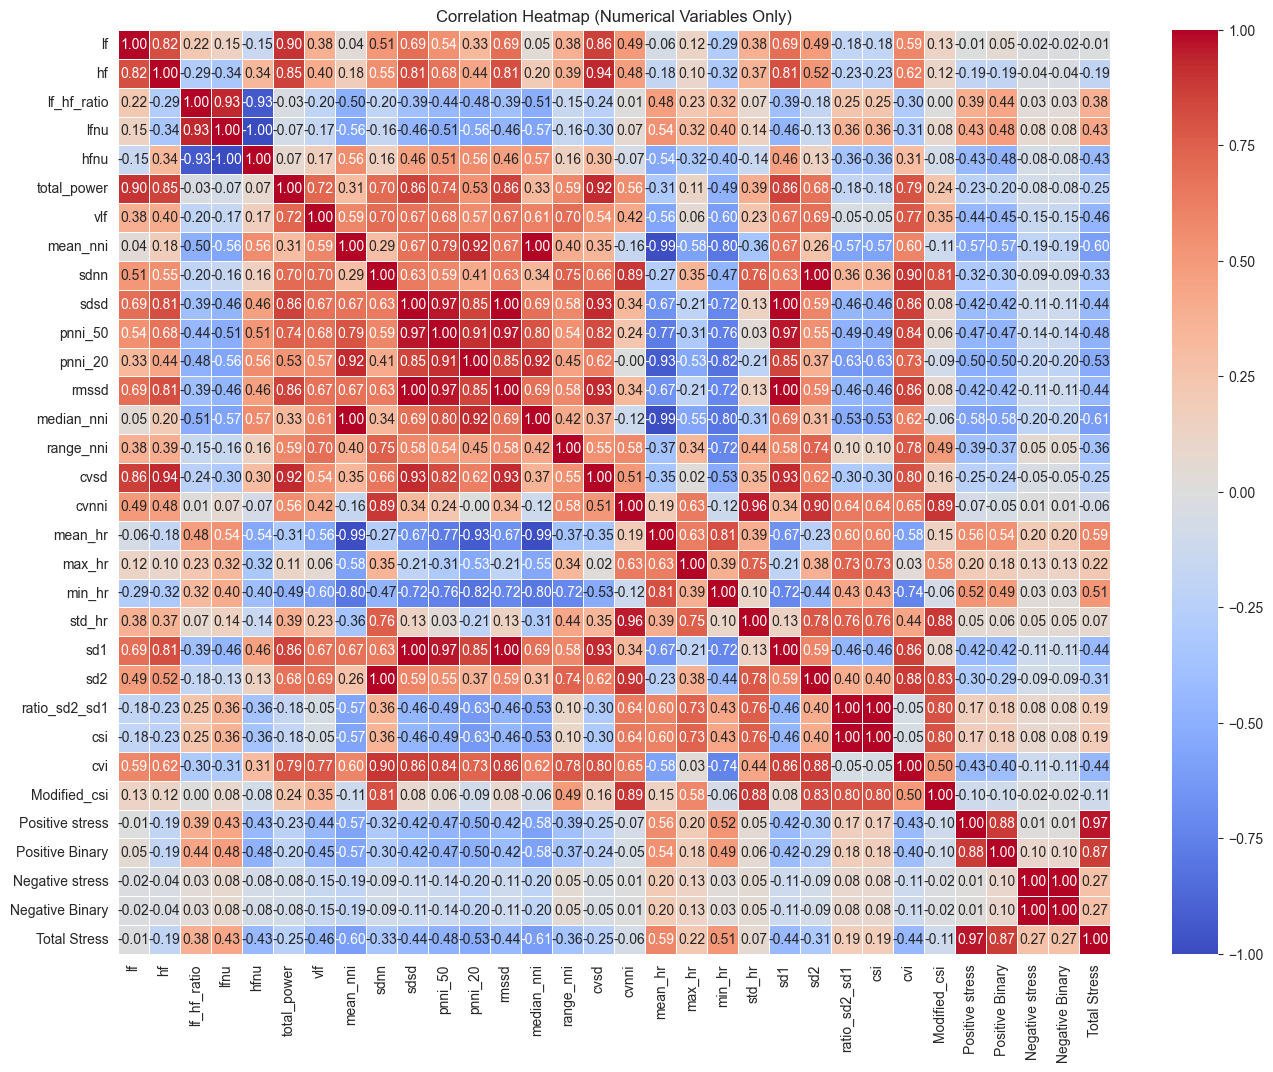

In [238]:
# Select only numerical columns from the dataset
numerical_df = merged_df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Variables Only)")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# List of HRV features to standardize
hrv_features = [
    'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf',
    'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
    'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr',
    'min_hr', 'std_hr', 'sd1', 'sd2', 'ratio_sd2_sd1', 'csi', 'cvi', 'Modified_csi'
]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the HRV features
merged_df[hrv_features] = scaler.fit_transform(merged_df[hrv_features])

In [240]:
merged_df

lf        hf  lf_hf_ratio      lfnu      hfnu  total_power  \
0  -0.472397 -0.436397     0.491758  0.634295 -0.634295    -0.563358   
1  -0.313132  0.090859    -0.955769 -0.820569  0.820569    -0.457290   
2  -0.748215 -0.384439    -0.533896 -0.238823  0.238823    -0.974482   
3   0.008117 -0.307762     0.906342  0.866121 -0.866121    -0.242820   
4   0.383902 -0.173972     0.954859  0.890292 -0.890292    -0.105408   
5  -0.365339 -0.297413     0.015060  0.295874 -0.295874    -0.431710   
6   0.210514 -0.383126     1.938312  1.283548 -1.283548    -0.263478   
7   0.100686  0.226966    -0.663836 -0.398094  0.398094    -0.090836   
8   0.074708  0.376850    -0.925921 -0.772587  0.772587    -0.089167   
9  -0.035982  0.004863    -0.380081 -0.068666  0.068666     0.278408   
10  0.110501 -0.300923     1.095495  0.957334 -0.957334    -0.142302   
11  1.056546  0.332134     0.219009  0.451915 -0.451915     0.739744   
12  2.425676  0.135609     2.553055  1.462141 -1.462141     1.462630   
13  2.283941  0.371133     1.442395  1.105669 -1.105669     1.455373   
14  1.209139 -0.148475     2.313365  1.397167 -1.397167     0.562720   
15  0.893274 -0.018323     1.103715  0.961120 -0.961120     0.623300   
16 -0.425459 -0.391920     0.344948  0.539527 -0.539527    -0.611533   
17  0.014874  0.286189    -0.861639 -0.673257  0.673257    -0.133554   
18  0.989623  0.641265    -0.416850 -0.107684  0.107684     0.463255   
19  0.765580  0.372631    -0.182841  0.124885 -0.124885     0.229661   
20  0.540217  0.053756     0.320987  0.523329 -0.523329     0.096506   
21  0.930145  0.006808     1.055393  0.938659 -0.938659     0.192324   
22  0.624197 -0.088899     0.979768  0.902488 -0.902488     0.084767   
23 -0.717468 -0.573117     0.777093  0.798917 -0.798917    -0.816621   
24 -0.609888 -0.519897     0.684922  0.748324 -0.748324    -0.735628   
25 -0.610426 -0.384764    -0.175407  0.131701 -0.131701    -0.615237   
26 -0.338933 -0.028541    -0.762903 -0.530522  0.530522    -0.344345   
27 -0.305718 -0.260361    -0.012589  0.273226 -0.273226    -0.680303   
28 -0.533016 -0.490795     0.702780  0.758308 -0.758308    -0.796797   
29 -0.555175 -0.394878     0.019400  0.299395 -0.299395    -0.651300   
30  0.530448 -0.157220     1.140167  0.977738 -0.977738    -0.081842   
31  0.068323 -0.365632     1.435320  1.102862 -1.102862    -0.220705   
32 -0.101710 -0.347788     0.893673  0.859717 -0.859717    -0.235842   
33 -0.854764 -0.508571    -0.237201  0.074038 -0.074038    -0.976318   
34 -0.094947 -0.360103     0.989859  0.907388 -0.907388    -0.238020   
35  0.068534 -0.188261     0.430032  0.595362 -0.595362    -0.271009   
36 -0.392661 -0.571380     2.059012  1.321852 -1.321852    -0.697590   
37 -0.859863 -0.483219    -0.397177 -0.086684  0.086684    -0.959749   
38 -0.191703 -0.261442     0.231594  0.460951 -0.460951    -0.559936   
39  0.217450 -0.126885     0.447125  0.606271 -0.606271    -0.162674   
40 -0.481982 -0.386611     0.167474  0.414223 -0.414223    -0.558223   
41 -0.741635 -0.400935    -0.447276 -0.140735  0.140735    -0.697221   
42 -0.846396 -0.503312    -0.240537  0.070859 -0.070859    -0.967745   
43 -0.397108 -0.438366     0.721999  0.768955 -0.768955    -0.458972   
44  0.184013 -0.132951     0.412663  0.584171 -0.584171    -0.272710   
45  0.844073 -0.188522     1.898302  1.270458 -1.270458     0.118222   
46  0.443325 -0.173821     1.064300  0.942837 -0.942837     0.131101   
47  0.294326 -0.206931     0.950425  0.888106 -0.888106     0.130739   
48  0.333075 -0.333119     1.830423  1.247781 -1.247781    -0.151897   
49 -0.378538 -0.341261     0.189803  0.430691 -0.430691    -0.496693   
50 -0.194042 -0.354178     0.708173  0.761306 -0.761306    -0.354401   
51 -0.661281 -0.464746     0.115183  0.374813 -0.374813    -0.785253   
52 -0.763082 -0.381980    -0.582155 -0.296191  0.296191    -0.718021   
53 -0.765621 -0.539296     0.289172  0.501485 -0.501485    -0.894929   
54 -0.715181 -0.358437    -0.552814 -0.261071  0.2

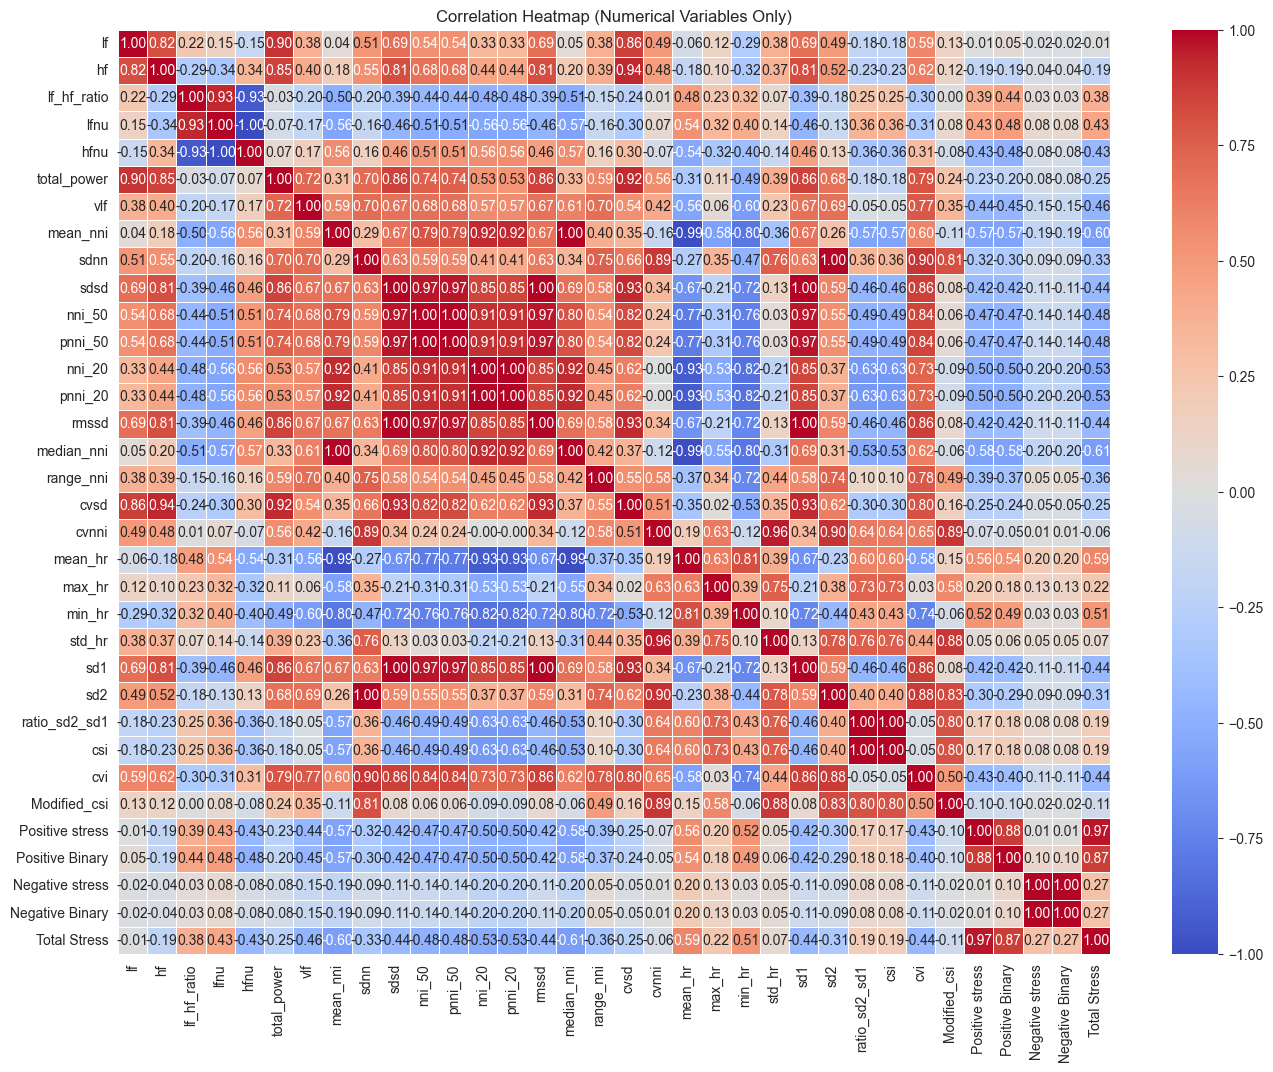

In [241]:
# Select only numerical columns from the dataset
numerical_df = merged_df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Variables Only)")
plt.show()


In [242]:
hrv_correlation_list = correlation_matrix['Total Stress'].sort_values(ascending=False)
print(hrv_correlation_list)
# Sorting the correlation values with 'Total Stress' based on the absolute value of their correlation coefficients
hrv_correlation_list_sorted = hrv_correlation_list.reindex(
    hrv_correlation_list.abs().sort_values(ascending=False).index
)

# Displaying the sorted list
hrv_correlation_list_sorted

Total Stress       1.000000
Positive stress    0.967763
Positive Binary    0.871983
mean_hr            0.588021
min_hr             0.513546
lfnu               0.434586
lf_hf_ratio        0.380047
Negative Binary    0.265881
Negative stress    0.265881
max_hr             0.224600
csi                0.185476
ratio_sd2_sd1      0.185476
std_hr             0.065331
lf                -0.011005
cvnni             -0.064295
Modified_csi      -0.106801
hf                -0.191045
total_power       -0.245174
cvsd              -0.250116
sd2               -0.314427
sdnn              -0.330701
range_nni         -0.361819
hfnu              -0.434586
rmssd             -0.436359
sd1               -0.436360
sdsd              -0.436360
cvi               -0.440263
vlf               -0.464719
pnni_50           -0.484247
nni_50            -0.484247
nni_20            -0.530436
pnni_20           -0.530436
mean_nni          -0.595726
median_nni        -0.608310
Name: Total Stress, dtype: float64


Total Stress       1.000000
Positive stress    0.967763
Positive Binary    0.871983
median_nni        -0.608310
mean_nni          -0.595726
mean_hr            0.588021
pnni_20           -0.530436
nni_20            -0.530436
min_hr             0.513546
nni_50            -0.484247
pnni_50           -0.484247
vlf               -0.464719
cvi               -0.440263
sdsd              -0.436360
sd1               -0.436360
rmssd             -0.436359
hfnu              -0.434586
lfnu               0.434586
lf_hf_ratio        0.380047
range_nni         -0.361819
sdnn              -0.330701
sd2               -0.314427
Negative stress    0.265881
Negative Binary    0.265881
cvsd              -0.250116
total_power       -0.245174
max_hr             0.224600
hf                -0.191045
ratio_sd2_sd1      0.185476
csi                0.185476
Modified_csi      -0.106801
std_hr             0.065331
cvnni             -0.064295
lf                -0.011005
Name: Total Stress, dtype: float64

In [243]:
# Most important features based on Correlation Coefficients
hrv_correlation_list_sorted = hrv_correlation_list_sorted.iloc[3:]  # Keeps all rows starting from index 3
print("Important features based on correlation:")
display(hrv_correlation_list_sorted)

Important features based on correlation:


median_nni        -0.608310
mean_nni          -0.595726
mean_hr            0.588021
pnni_20           -0.530436
nni_20            -0.530436
min_hr             0.513546
nni_50            -0.484247
pnni_50           -0.484247
vlf               -0.464719
cvi               -0.440263
sdsd              -0.436360
sd1               -0.436360
rmssd             -0.436359
hfnu              -0.434586
lfnu               0.434586
lf_hf_ratio        0.380047
range_nni         -0.361819
sdnn              -0.330701
sd2               -0.314427
Negative stress    0.265881
Negative Binary    0.265881
cvsd              -0.250116
total_power       -0.245174
max_hr             0.224600
hf                -0.191045
ratio_sd2_sd1      0.185476
csi                0.185476
Modified_csi      -0.106801
std_hr             0.065331
cvnni             -0.064295
lf                -0.011005
Name: Total Stress, dtype: float64

In [244]:
# Feature Selection
from sklearn.ensemble import RandomForestRegressor

# Ensure all numeric columns for feature selection
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
target_variable = 'Total Stress'
features = numeric_columns.drop(target_variable)


# Step 2: Feature selection using Random Forest (importance-based)
X = merged_df[features]
y = merged_df[target_variable]

# Assuming data is already scaled, skip scaling
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X, y)

# Extract feature importances
importances = pd.Series(rf.feature_importances_, index=features)
important_features_rf = importances.nlargest(10)


print("\nImportant features based on Random Forest:")
print(important_features_rf)



Important features based on Random Forest:
Positive stress    0.536932
Positive Binary    0.397311
Negative stress    0.027490
Negative Binary    0.020861
nni_20             0.002349
pnni_20            0.001828
mean_hr            0.001460
range_nni          0.001236
cvnni              0.001208
cvsd               0.001186
dtype: float64


In [247]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the features (X) and targets (y)
X = merged_df[['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf',
               'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20',
               'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni',
               'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'sd1', 'sd2',
               'ratio_sd2_sd1', 'csi', 'cvi', 'Modified_csi']]
y = merged_df[['Positive stress', 'Negative stress', 'Positive Binary', 'Negative Binary', 'Total Stress']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor (supports multi-target regression natively)
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model for each target
for i, target in enumerate(y.columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{target} - MSE: {mse}")
    print(f"{target} - R2: {r2}")


Positive stress - MSE: 0.5962450000000001
Positive stress - R2: 0.04980876494023889
Negative stress - MSE: 0.168545
Negative stress - R2: -0.053406249999999655
Positive Binary - MSE: 0.17824
Positive Binary - R2: 0.2798383838383839
Negative Binary - MSE: 0.168545
Negative Binary - R2: -0.053406249999999655
Total Stress - MSE: 0.7474300000000001
Total Stress - R2: 0.19414555256064658


General Observations
Low R² Across Targets: Most targets show low R² values, indicating the model struggles to explain the variance in the data.
Better for Binary Targets: The model performs slightly better for binary targets (e.g., Positive Binary).


Results are based on this below!!!


Processing target: Positive stress

Processing model: Linear Regression
Linear Regression Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.875
  Mean Absolute Error (MAE): 0.658
  R² Score: -0.394
  Explained Variance Score: -0.361


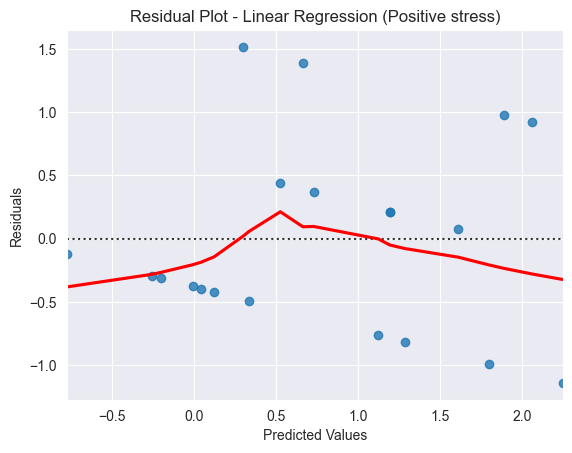

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


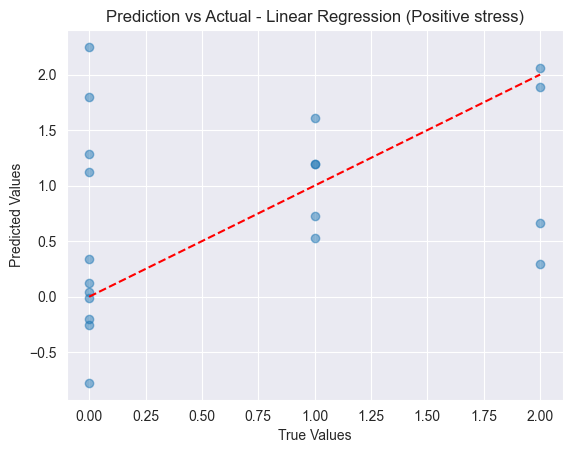

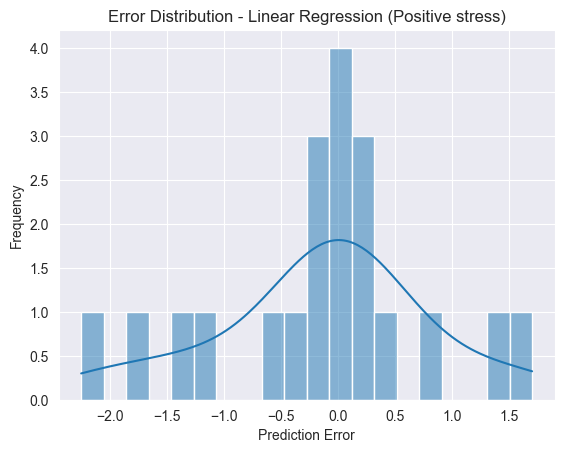


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.530
  Mean Absolute Error (MAE): 0.491
  R² Score: 0.156
  Explained Variance Score: 0.234


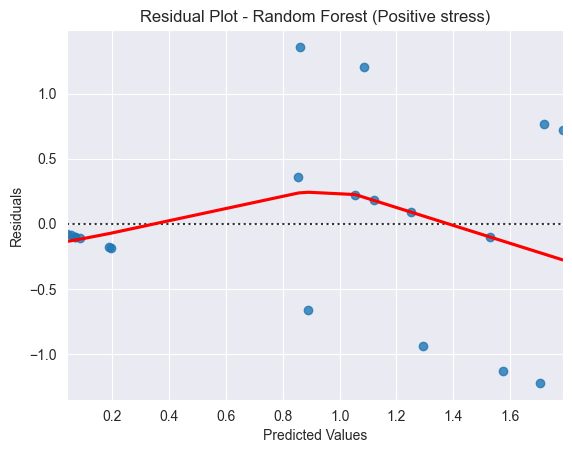

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


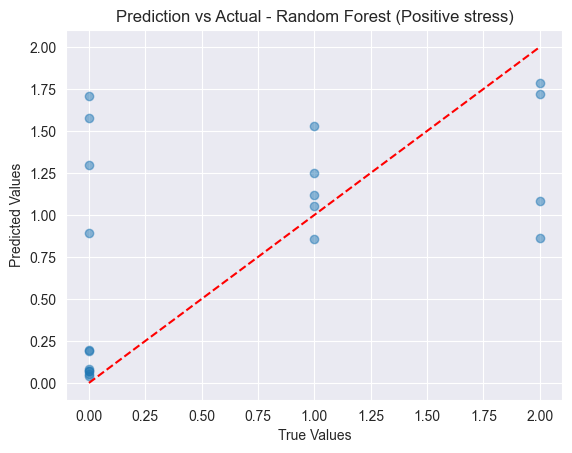

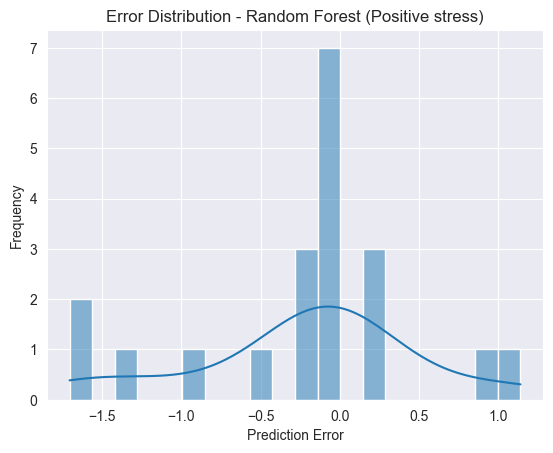


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.1}
Lasso Regression Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.516
  Mean Absolute Error (MAE): 0.524
  R² Score: 0.177
  Explained Variance Score: 0.196


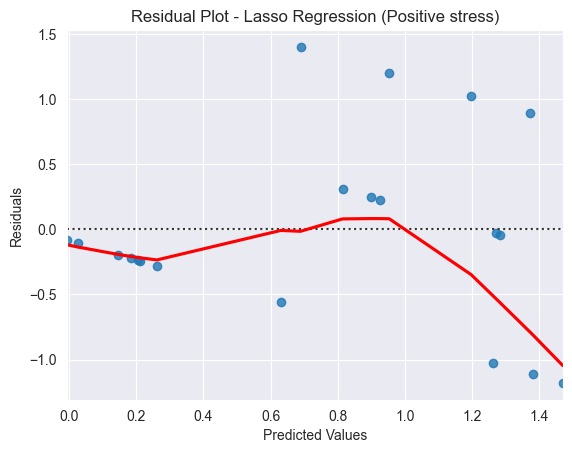

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


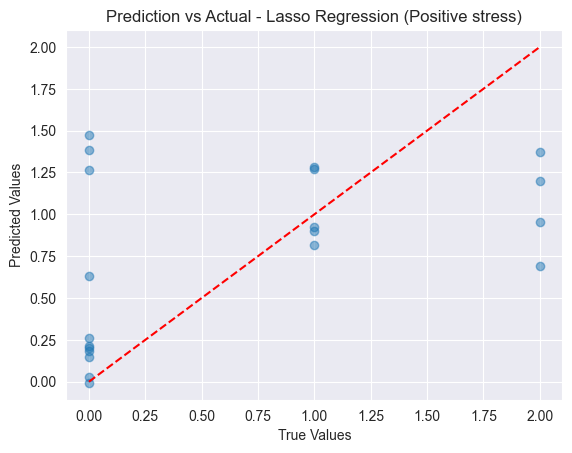

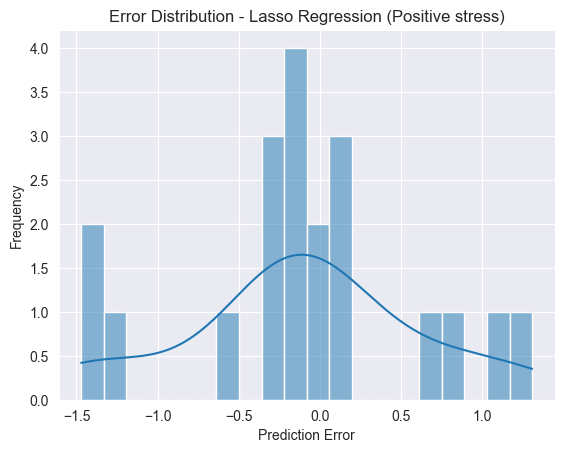


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 10}
Ridge Regression Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.568
  Mean Absolute Error (MAE): 0.539
  R² Score: 0.095
  Explained Variance Score: 0.117


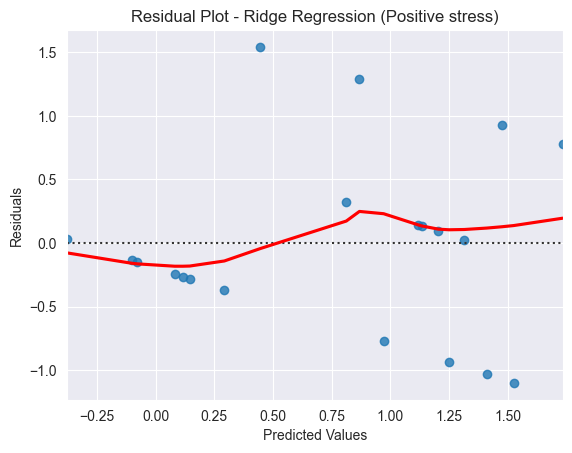

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


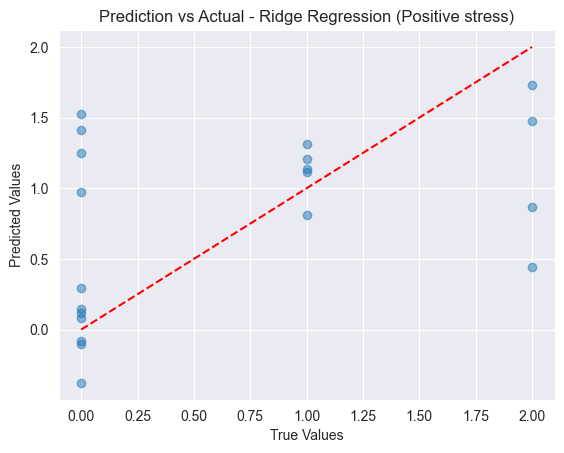

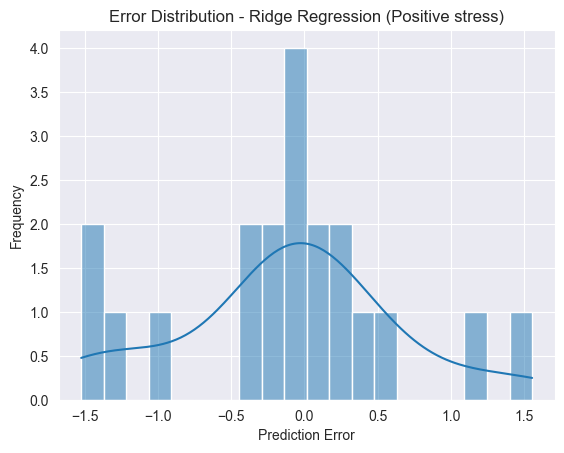


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.5}
Support Vector Regressor Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.613
  Mean Absolute Error (MAE): 0.630
  R² Score: 0.024
  Explained Variance Score: 0.173


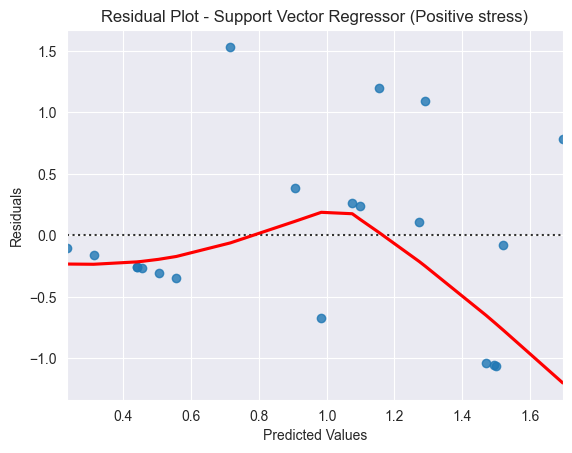

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


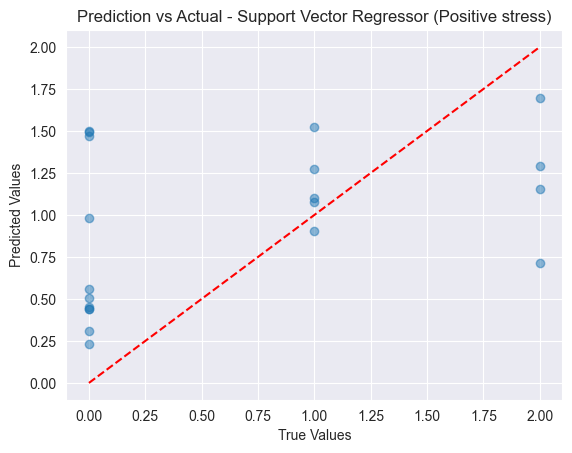

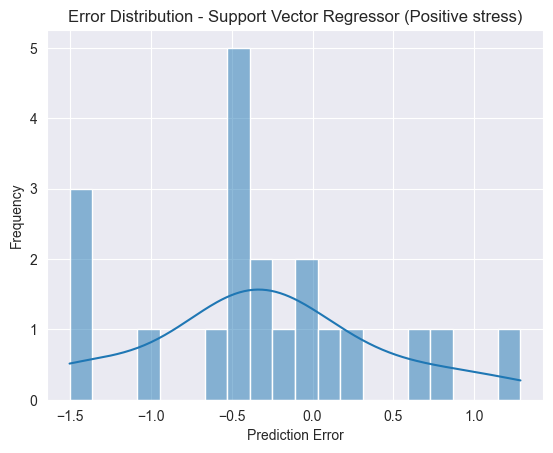


Processing target: Negative stress

Processing model: Linear Regression
Linear Regression Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.188
  Mean Absolute Error (MAE): 0.246
  R² Score: -0.175
  Explained Variance Score: -0.052


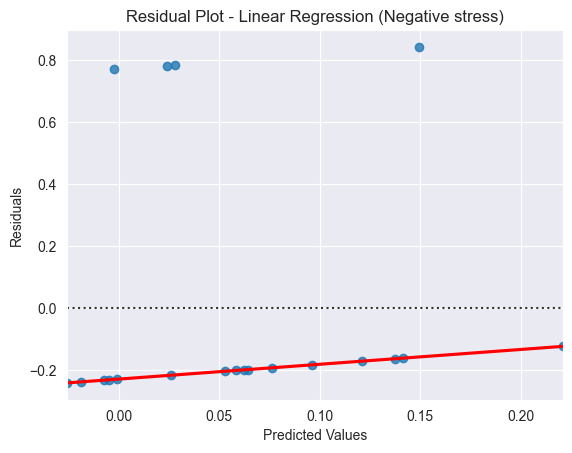

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


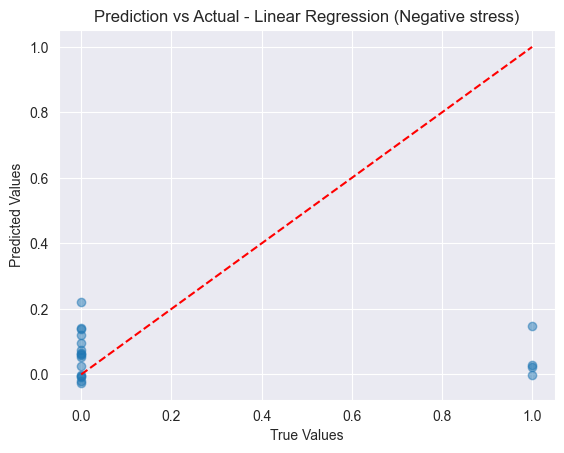

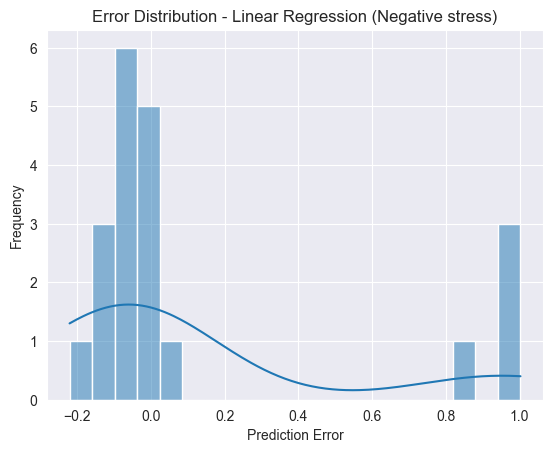


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
Random Forest Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.175
  Mean Absolute Error (MAE): 0.200
  R² Score: -0.096
  Explained Variance Score: 0.089


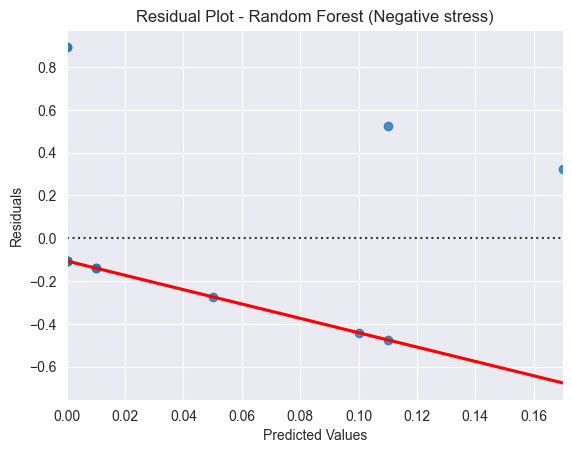

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


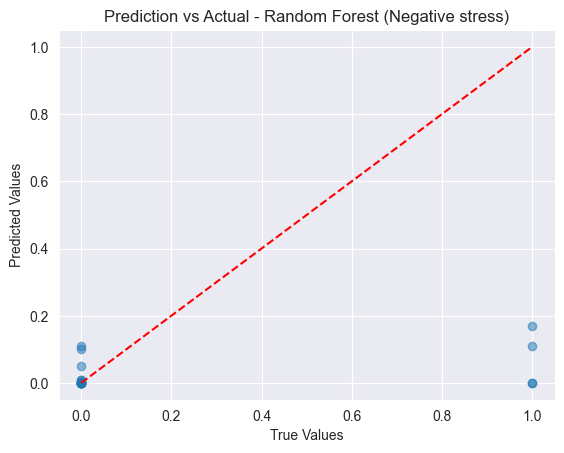

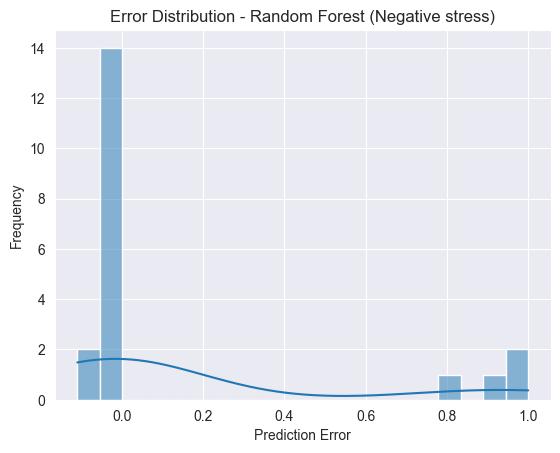


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.1}
Lasso Regression Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.190
  Mean Absolute Error (MAE): 0.216
  R² Score: -0.189
  Explained Variance Score: 0.000


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


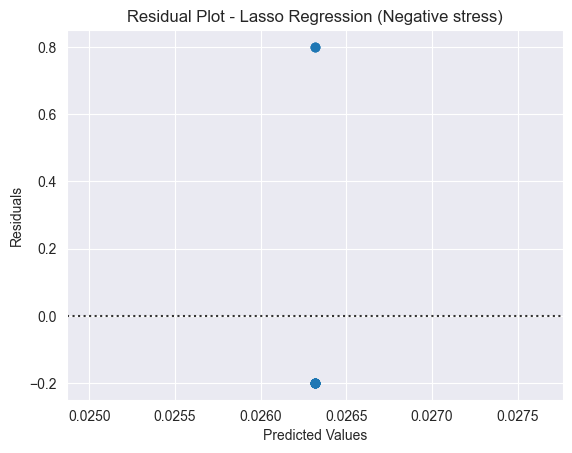

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


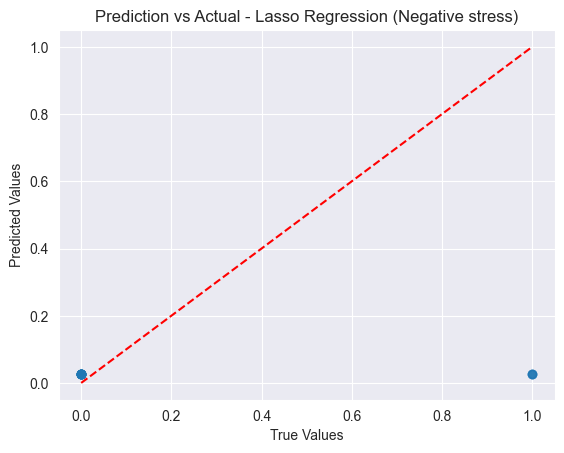

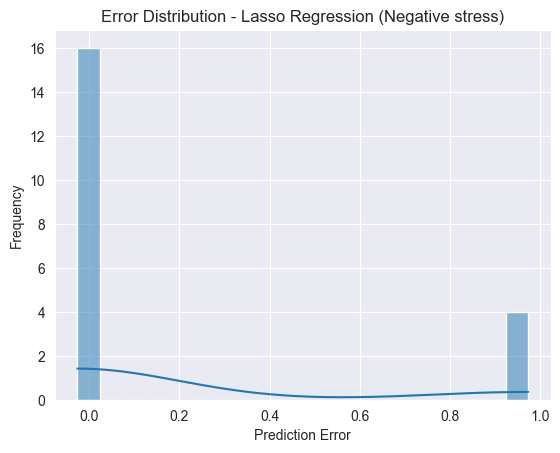


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 100}
Ridge Regression Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.185
  Mean Absolute Error (MAE): 0.219
  R² Score: -0.154
  Explained Variance Score: 0.046


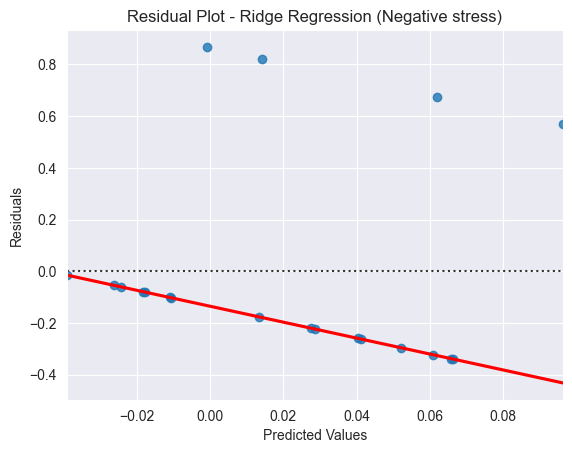

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


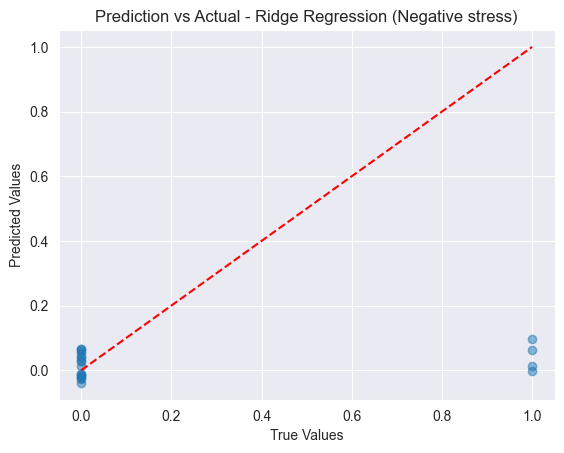

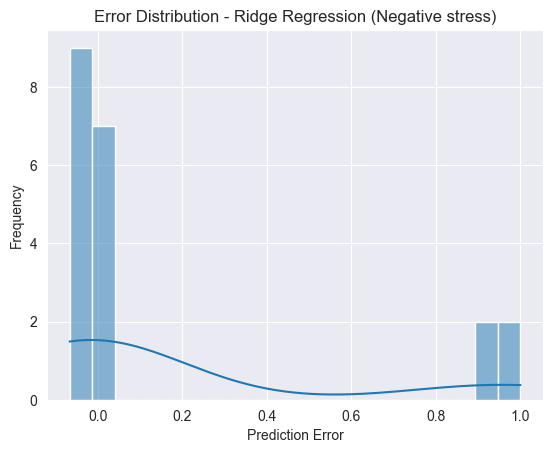


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.1}
Support Vector Regressor Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.171
  Mean Absolute Error (MAE): 0.230
  R² Score: -0.067
  Explained Variance Score: 0.048


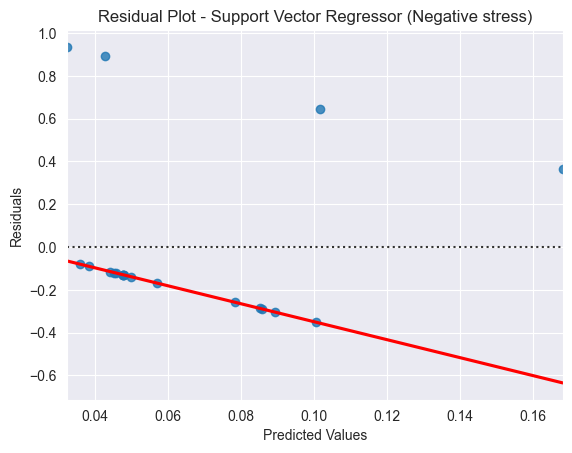

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


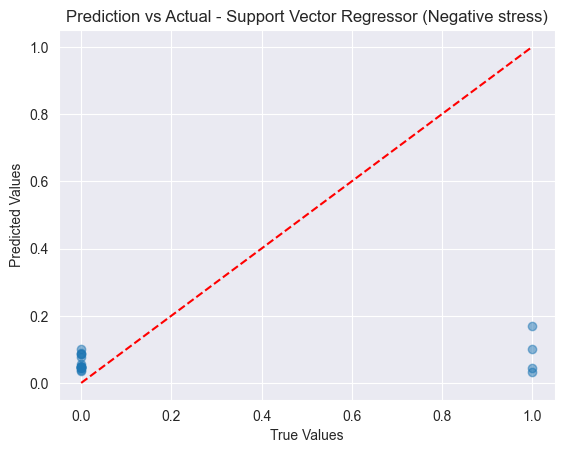

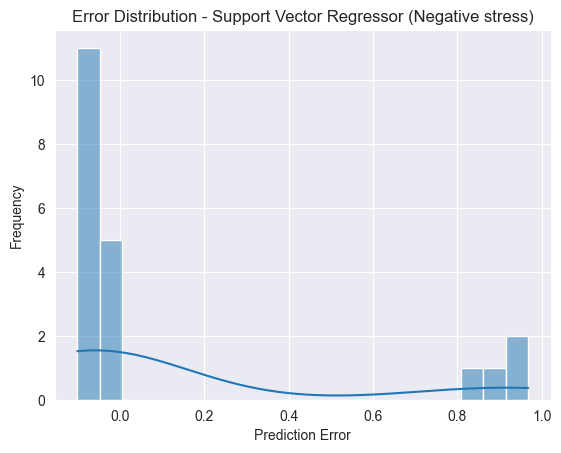


Processing target: Positive Binary

Processing model: Linear Regression
Linear Regression Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.197
  Mean Absolute Error (MAE): 0.318
  R² Score: 0.202
  Explained Variance Score: 0.221


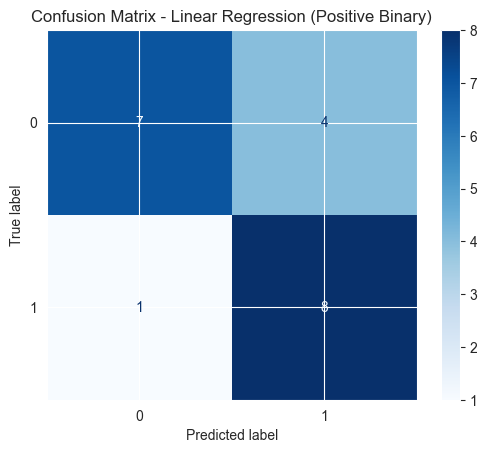

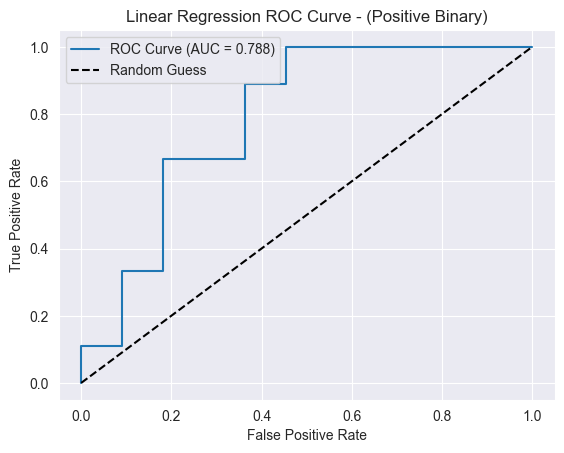


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Random Forest Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.148
  Mean Absolute Error (MAE): 0.284
  R² Score: 0.401
  Explained Variance Score: 0.413


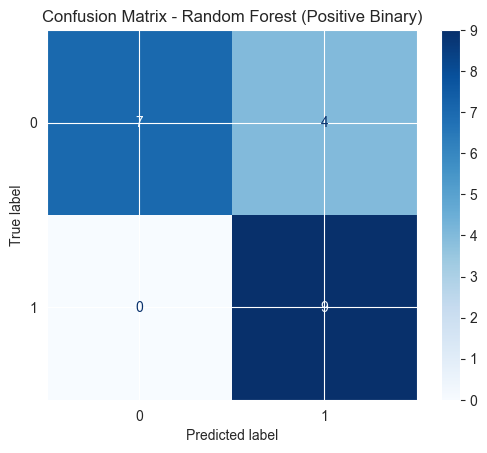

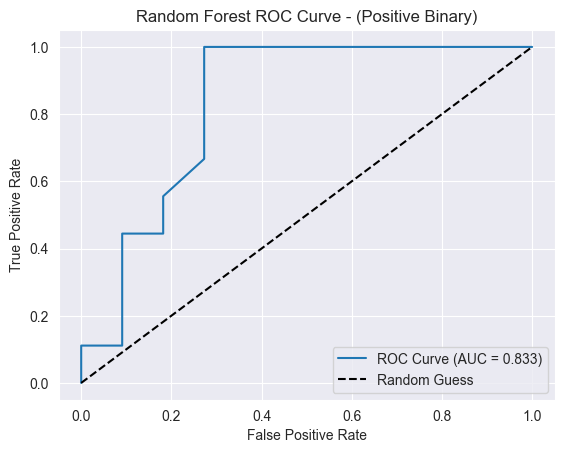


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.01}
Lasso Regression Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.163
  Mean Absolute Error (MAE): 0.305
  R² Score: 0.340
  Explained Variance Score: 0.342


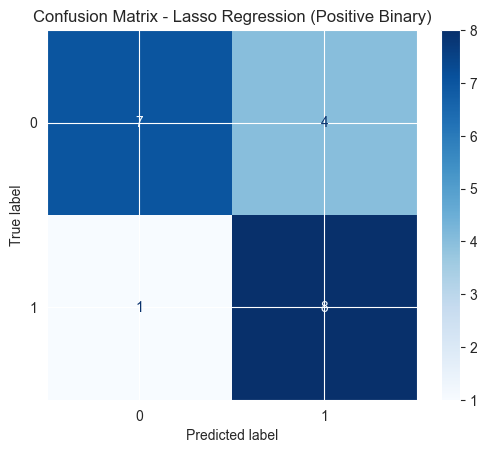

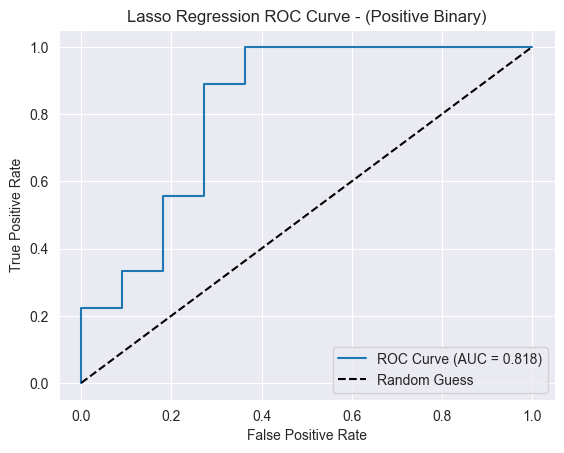


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 10}
Ridge Regression Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.171
  Mean Absolute Error (MAE): 0.323
  R² Score: 0.308
  Explained Variance Score: 0.310


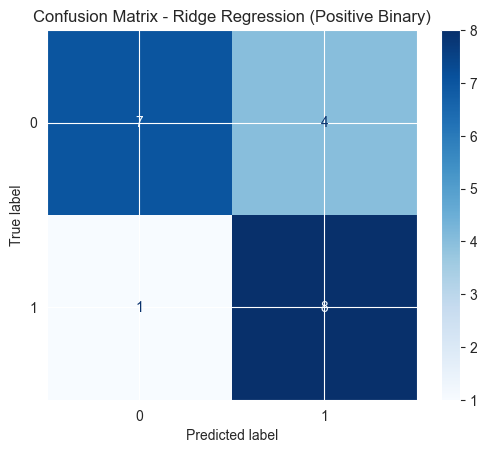

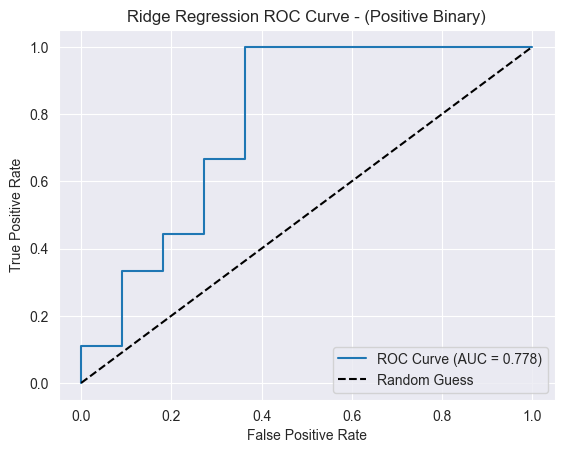


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.2}
Support Vector Regressor Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.160
  Mean Absolute Error (MAE): 0.290
  R² Score: 0.353
  Explained Variance Score: 0.365


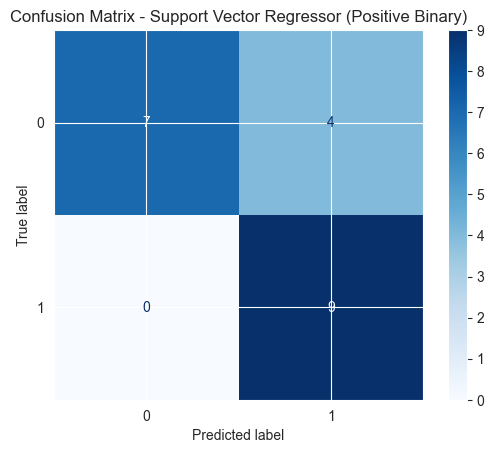

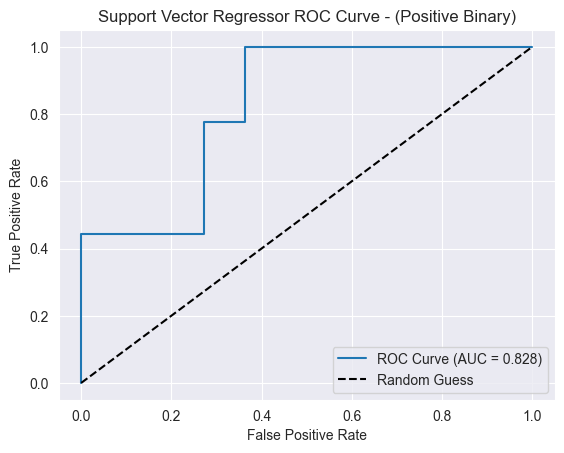


Processing target: Negative Binary

Processing model: Linear Regression
Linear Regression Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.188
  Mean Absolute Error (MAE): 0.246
  R² Score: -0.175
  Explained Variance Score: -0.052


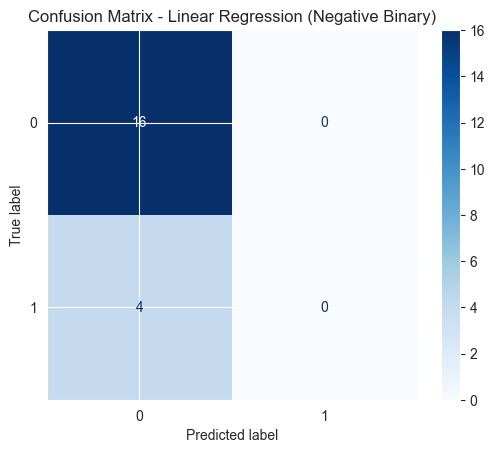

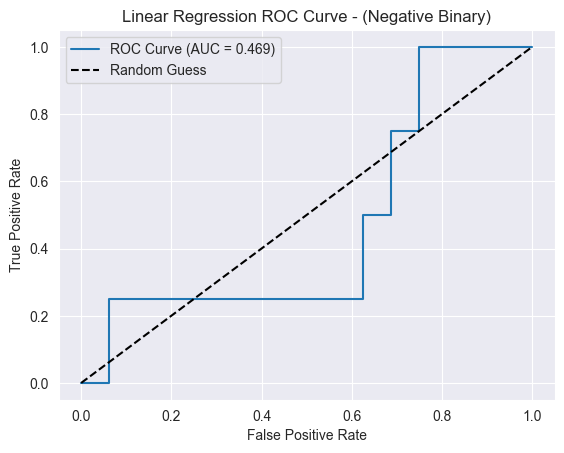


Processing model: Random Forest
Best parameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
Random Forest Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.175
  Mean Absolute Error (MAE): 0.200
  R² Score: -0.096
  Explained Variance Score: 0.089


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666

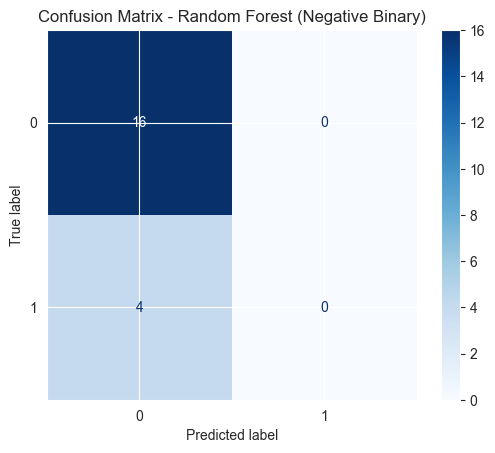

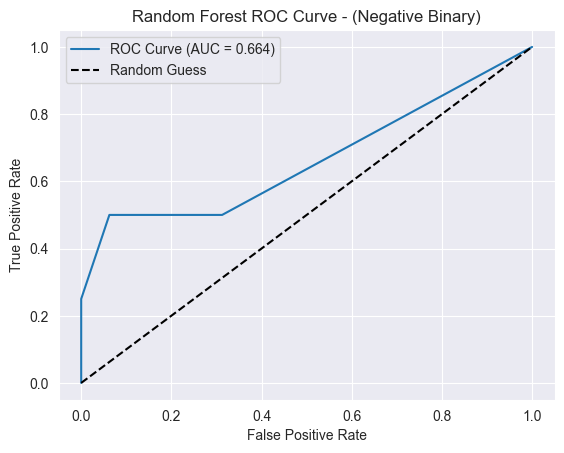


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.1}
Lasso Regression Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.190
  Mean Absolute Error (MAE): 0.216
  R² Score: -0.189
  Explained Variance Score: 0.000


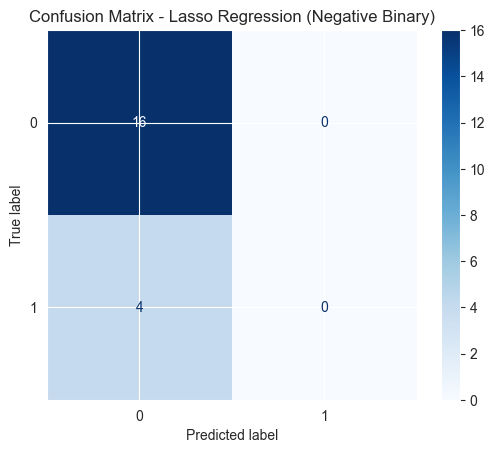

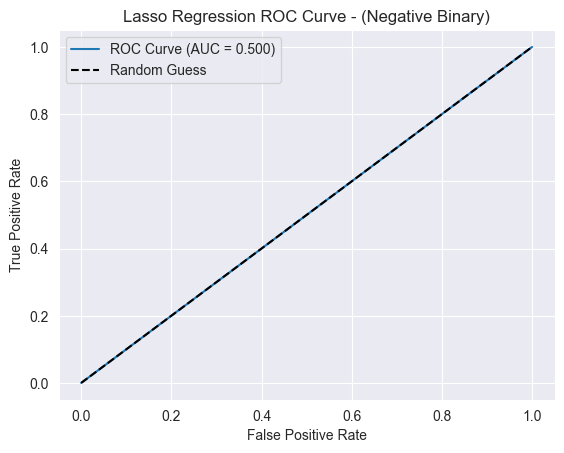


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 100}
Ridge Regression Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.185
  Mean Absolute Error (MAE): 0.219
  R² Score: -0.154
  Explained Variance Score: 0.046


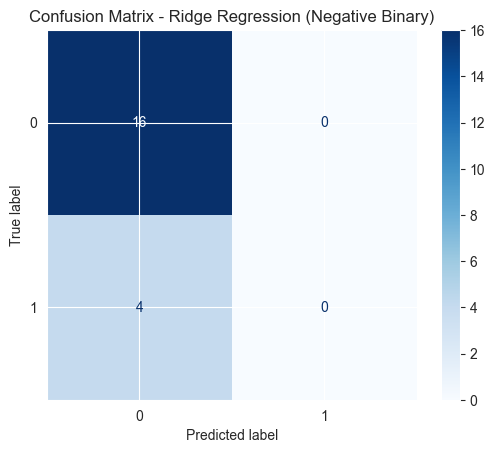

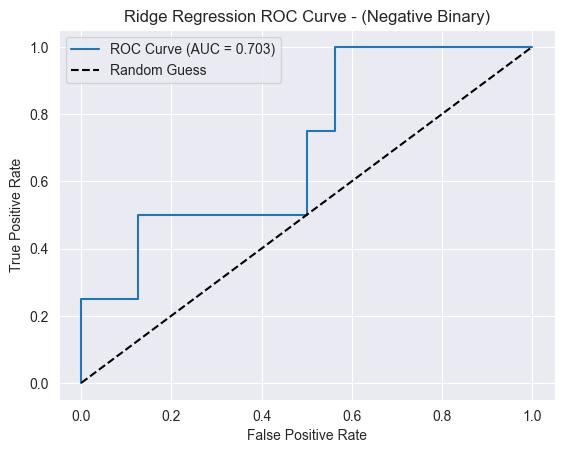


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.1}
Support Vector Regressor Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.171
  Mean Absolute Error (MAE): 0.230
  R² Score: -0.067
  Explained Variance Score: 0.048


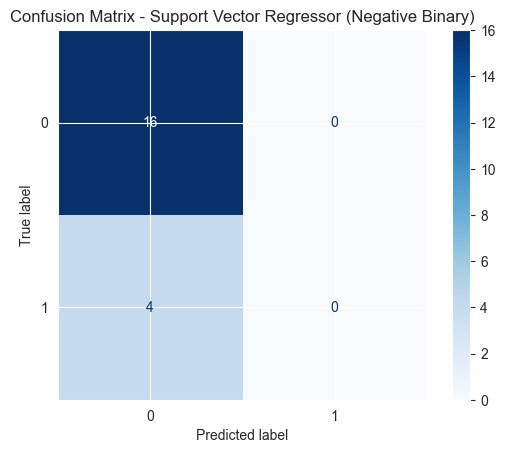

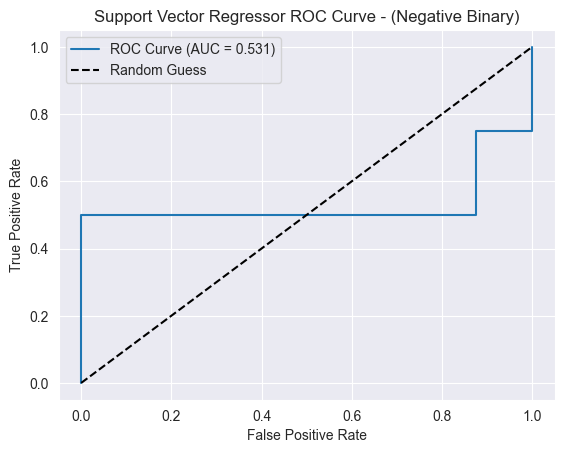


Processing target: Total Stress

Processing model: Linear Regression
Linear Regression Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.984
  Mean Absolute Error (MAE): 0.690
  R² Score: -0.061
  Explained Variance Score: -0.061


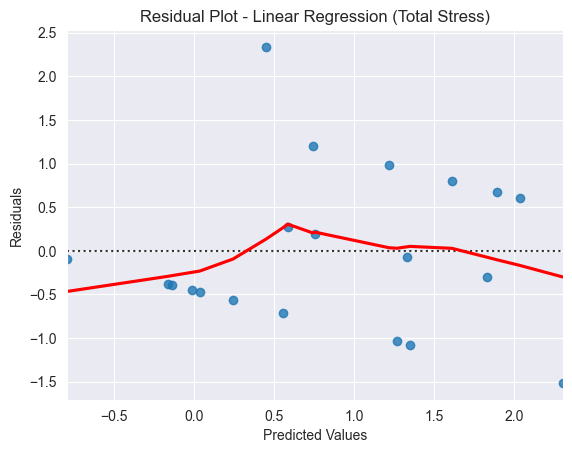

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


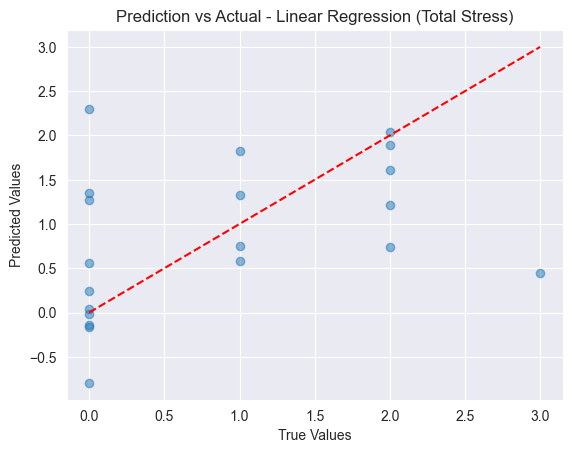

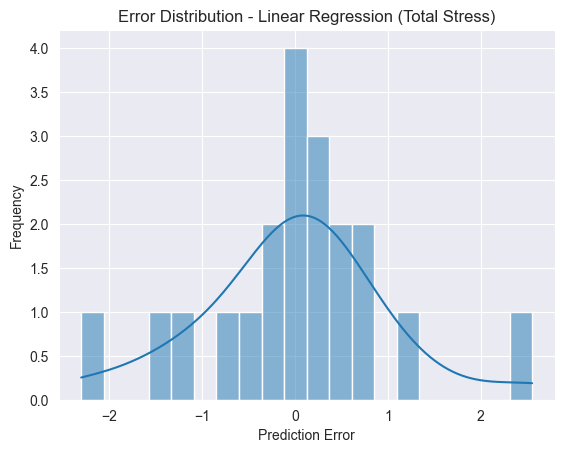


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.742
  Mean Absolute Error (MAE): 0.579
  R² Score: 0.200
  Explained Variance Score: 0.202


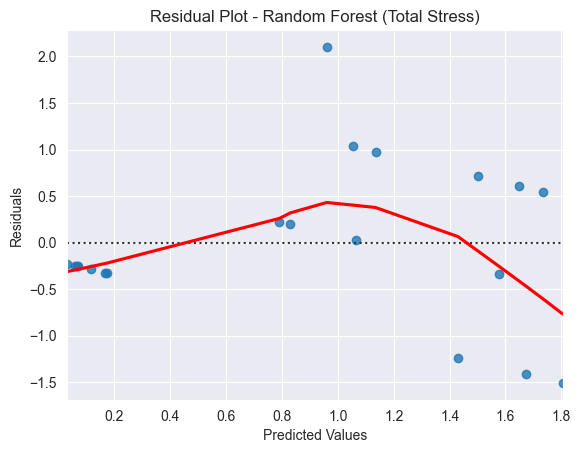

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


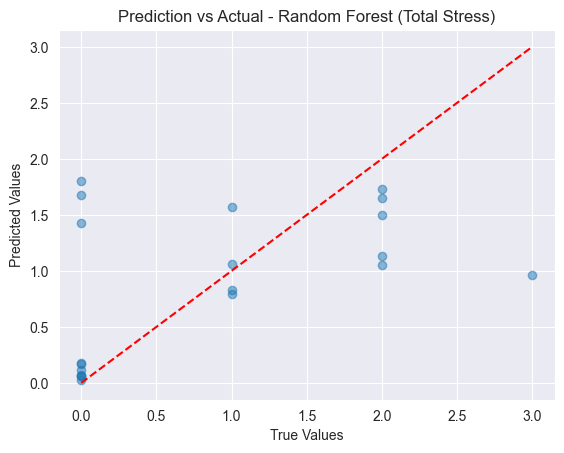

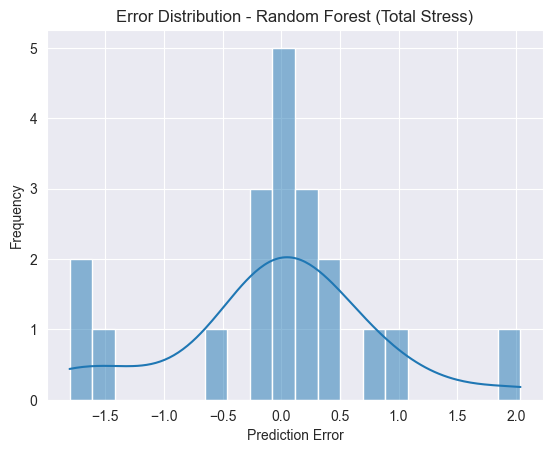


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.1}
Lasso Regression Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.738
  Mean Absolute Error (MAE): 0.615
  R² Score: 0.204
  Explained Variance Score: 0.211


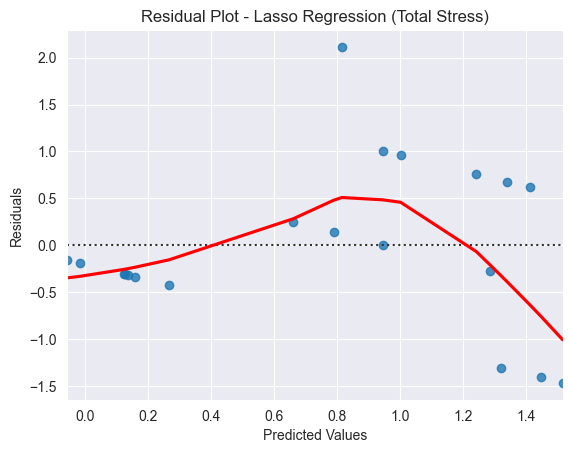

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


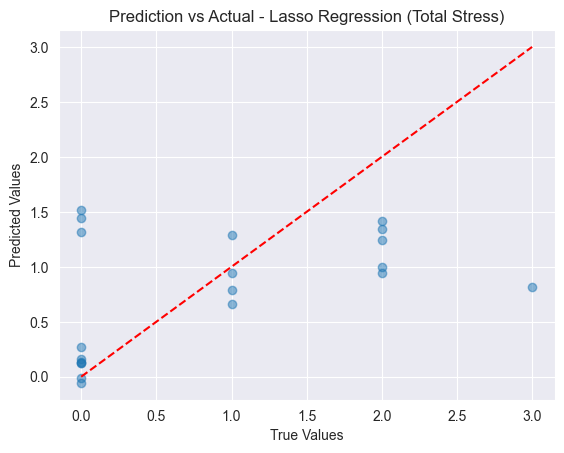

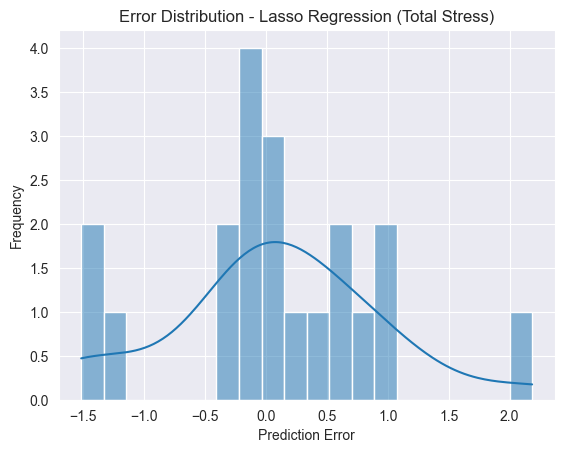


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 10}
Ridge Regression Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.754
  Mean Absolute Error (MAE): 0.583
  R² Score: 0.187
  Explained Variance Score: 0.190


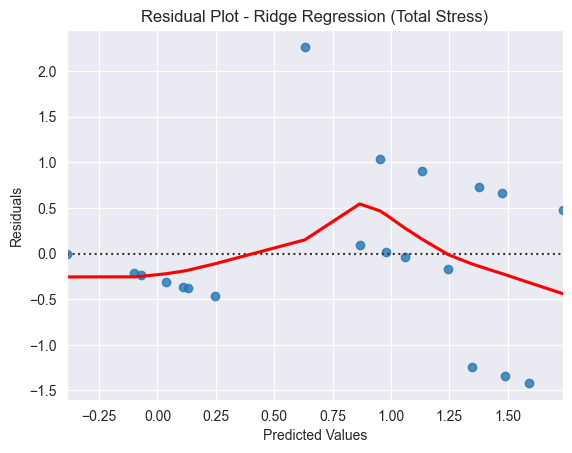

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


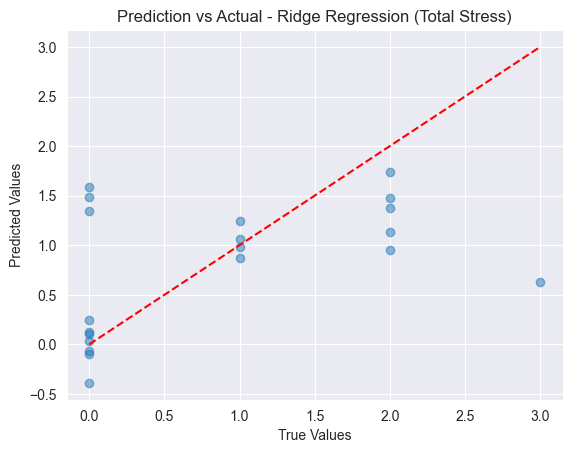

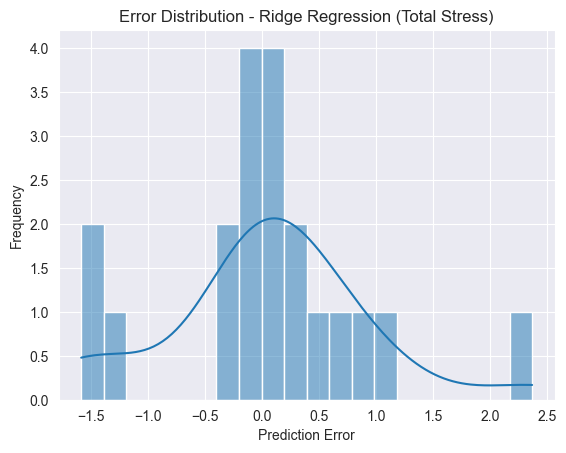


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.2}
Support Vector Regressor Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.817
  Mean Absolute Error (MAE): 0.570
  R² Score: 0.119
  Explained Variance Score: 0.125


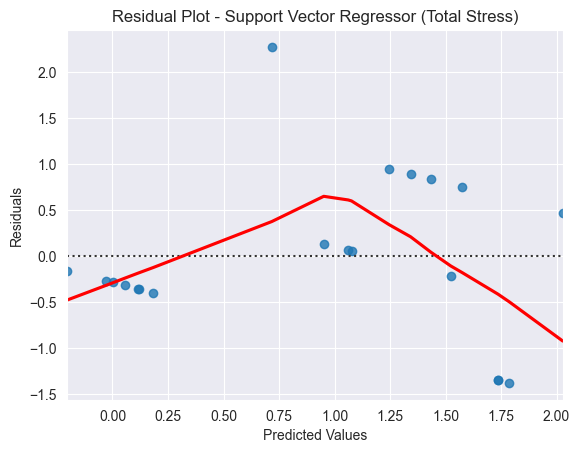

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\2642219601.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


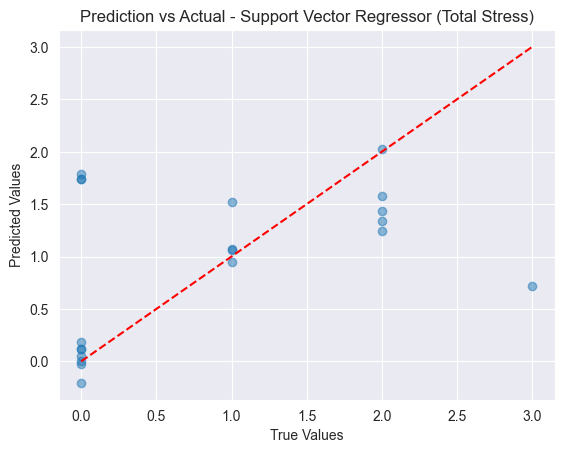

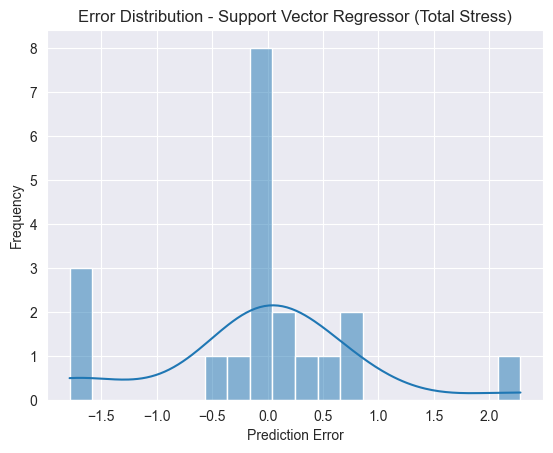

In [252]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)


# Define the features (X) and targets (y)
X = merged_df[['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf',
               'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20',
               'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni',
               'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'sd1', 'sd2',
               'ratio_sd2_sd1', 'csi', 'cvi', 'Modified_csi']]
y_targets = {
    'Positive stress': merged_df['Positive stress'],
    'Negative stress': merged_df['Negative stress'],
    'Positive Binary': merged_df['Positive Binary'],
    'Negative Binary': merged_df['Negative Binary'],
    'Total Stress': merged_df['Total Stress']
}

# Standardize X (already scaled, so skipping StandardScaler)
X_scaled = X
# Define models and parameters
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Support Vector Regressor': SVR()
}

param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20]
    },
    'Lasso Regression': {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    },
    'Ridge Regression': {
        'alpha': [0.1, 1, 10, 100]
    },
    'Support Vector Regressor': {
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.5]
    }
}

# Define target variables
target_variables = [
    ('Positive stress', merged_df['Positive stress']),
    ('Negative stress', merged_df['Negative stress']),
    ('Positive Binary', merged_df['Positive Binary']),
    ('Negative Binary', merged_df['Negative Binary']),
    ('Total Stress', merged_df['Total Stress'])
]


# Iterate through targets and models
for target_name, target in target_variables:
    print(f"\nProcessing target: {target_name}")
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

    for model_name, model in models.items():
        print(f"\nProcessing model: {model_name}")
        param_grid = param_grids[model_name]

        # Grid Search
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        else:
            model.fit(X_train, y_train)

        # Predictions and metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        print(f"{model_name} Performance Metrics for {target_name}:")
        print(f"  Mean Squared Error (MSE): {mse:.3f}")
        print(f"  Mean Absolute Error (MAE): {mae:.3f}")
        print(f"  R² Score: {r2:.3f}")
        print(f"  Explained Variance Score: {evs:.3f}")

        # Visualizations for binary targets
        if target_name in ['Positive Binary', 'Negative Binary']:
            binary_predictions = (y_pred >= 0.5).astype(int)
            cm = confusion_matrix(y_test, binary_predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            disp.plot(cmap='Blues')
            plt.title(f'Confusion Matrix - {model_name} ({target_name})')
            plt.show()

            # ROC Curve
            roc_auc = roc_auc_score(y_test, y_pred)
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.title(f'{model_name} ROC Curve - ({target_name})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.show()

        # Visualizations for continuous targets
        else:
            # Residual Plot
            sns.residplot(x=y_pred, y=(y_test - y_pred), lowess=True, line_kws={'color': 'red'})
            plt.title(f'Residual Plot - {model_name} ({target_name})')
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.show()

            # Prediction vs True Values Scatter Plot
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')
            plt.title(f'Prediction vs Actual - {model_name} ({target_name})')
            plt.xlabel('True Values')
            plt.ylabel('Predicted Values')
            plt.show()

            # Error Distribution
            sns.histplot((y_test - y_pred), kde=True, bins=20)
            plt.title(f'Error Distribution - {model_name} ({target_name})')
            plt.xlabel('Prediction Error')
            plt.ylabel('Frequency')
            plt.show()


Include only the most important features based on correlation


Processing target: Positive stress

Processing model: Linear Regression
Linear Regression Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.878
  Mean Absolute Error (MAE): 0.657
  R² Score: -0.399
  Explained Variance Score: -0.372


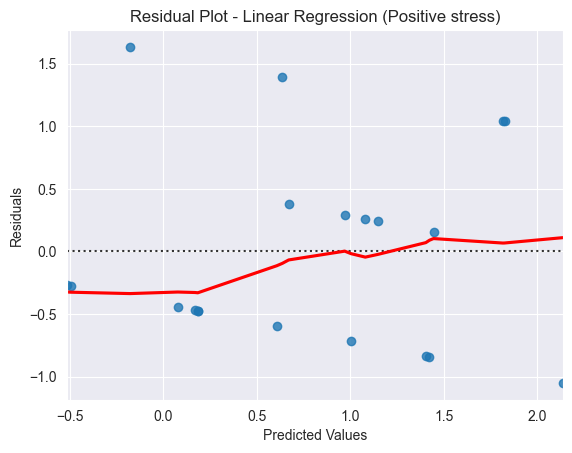

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


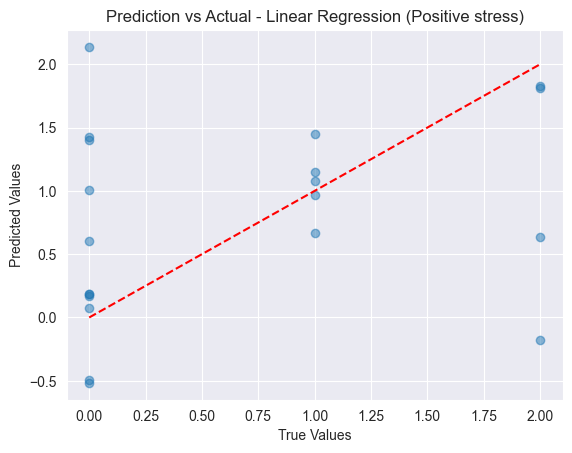

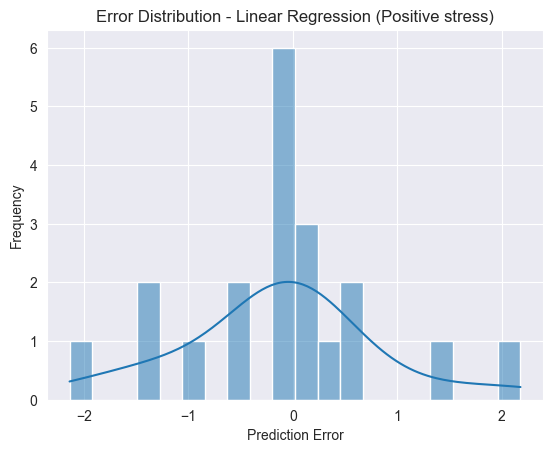


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666,

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Random Forest Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.534
  Mean Absolute Error (MAE): 0.489
  R² Score: 0.149
  Explained Variance Score: 0.206


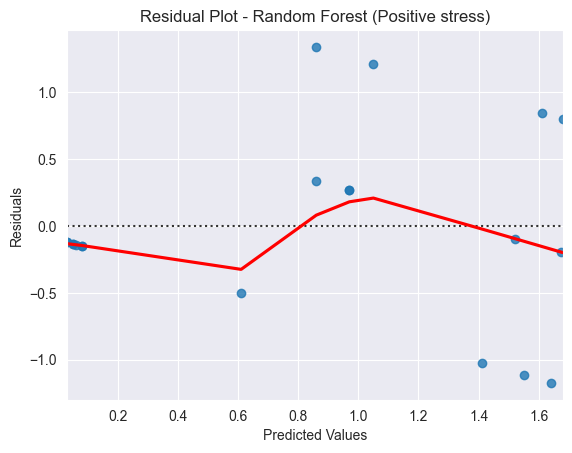

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


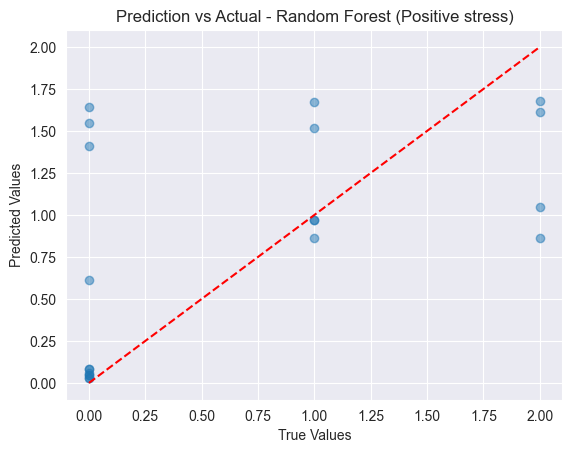

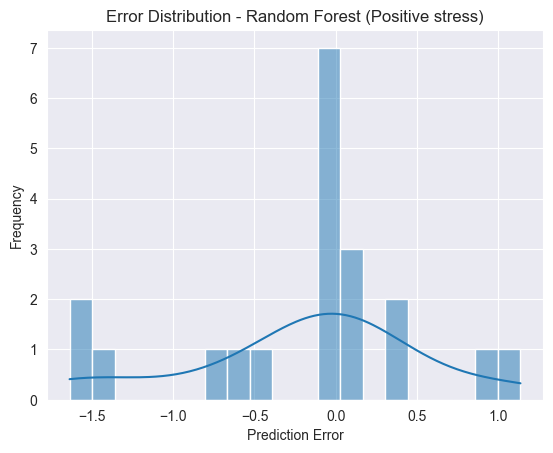


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.01}
Lasso Regression Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.622
  Mean Absolute Error (MAE): 0.533
  R² Score: 0.009
  Explained Variance Score: 0.019


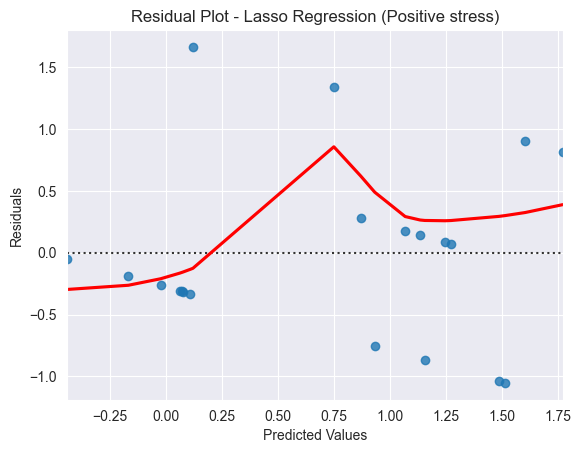

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


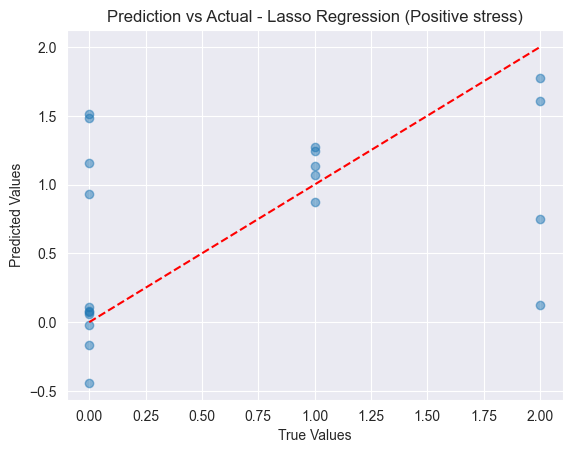

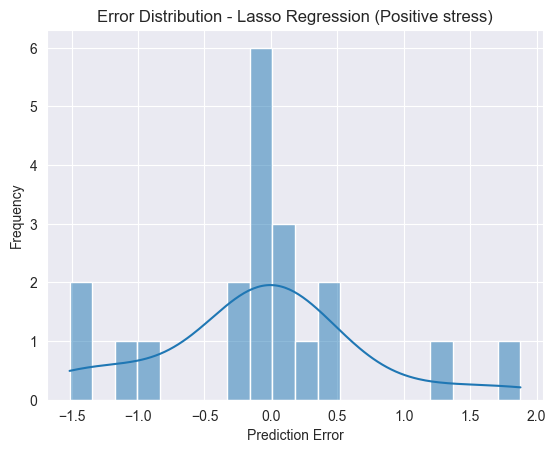


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 10}
Ridge Regression Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.579
  Mean Absolute Error (MAE): 0.548
  R² Score: 0.078
  Explained Variance Score: 0.097


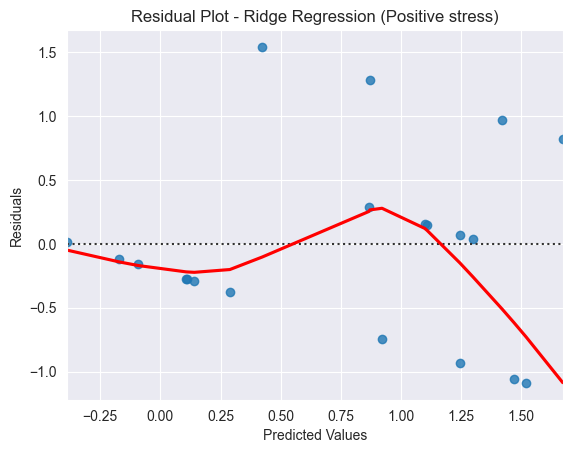

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


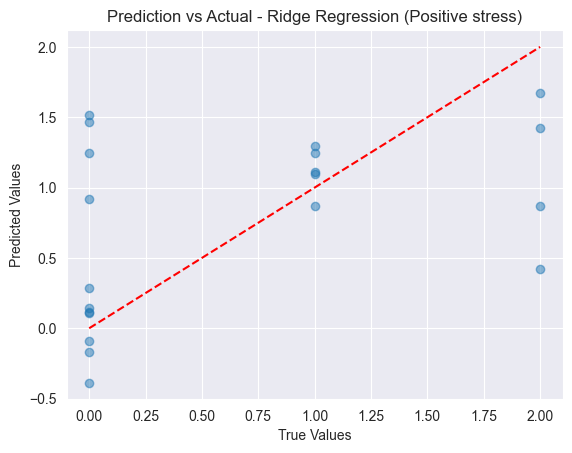

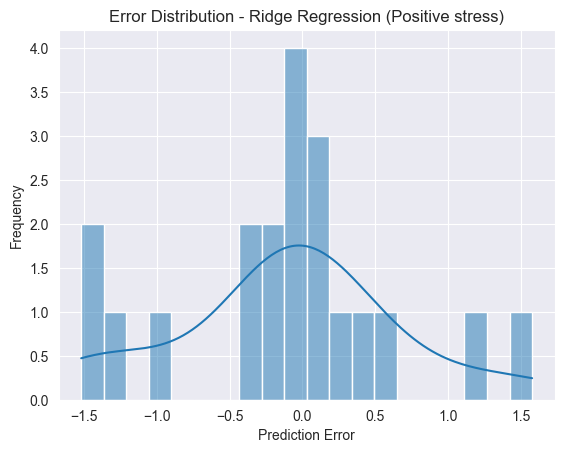


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.5}
Support Vector Regressor Performance Metrics for Positive stress:
  Mean Squared Error (MSE): 0.662
  Mean Absolute Error (MAE): 0.653
  R² Score: -0.055
  Explained Variance Score: 0.075


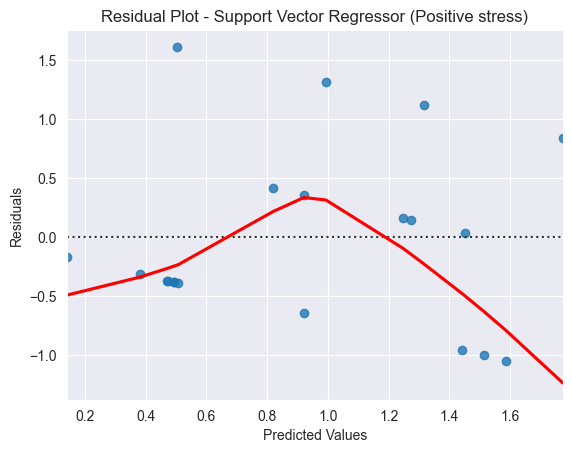

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


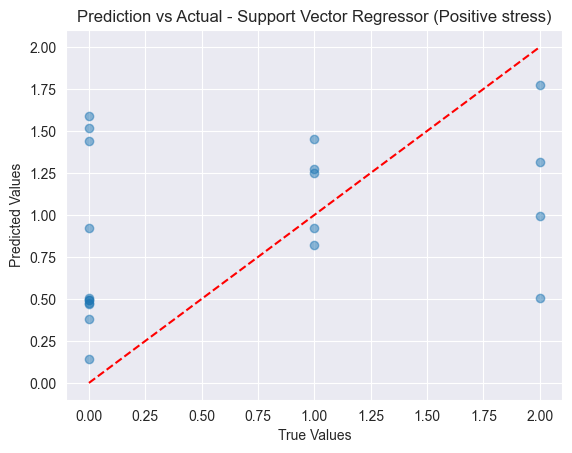

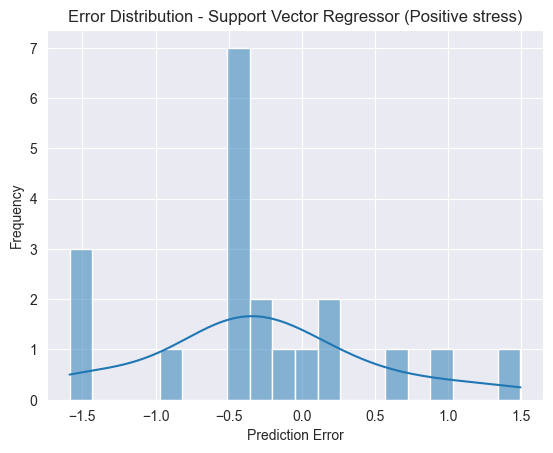


Processing target: Negative stress

Processing model: Linear Regression
Linear Regression Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.172
  Mean Absolute Error (MAE): 0.232
  R² Score: -0.074
  Explained Variance Score: 0.088


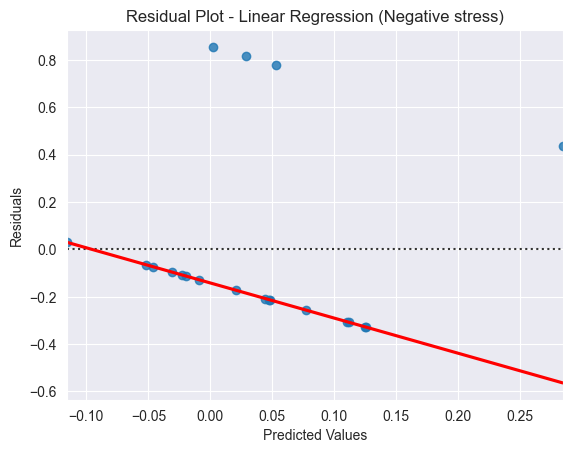

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


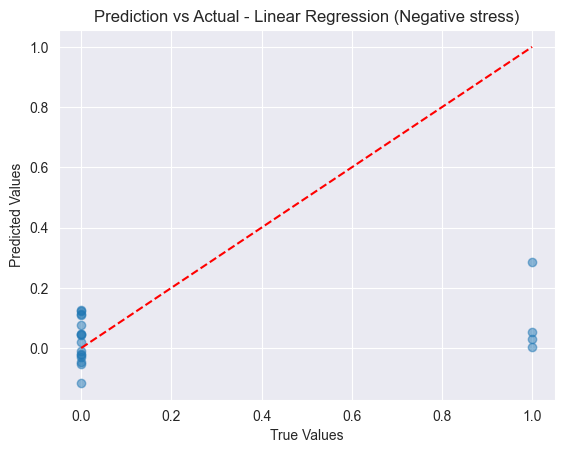

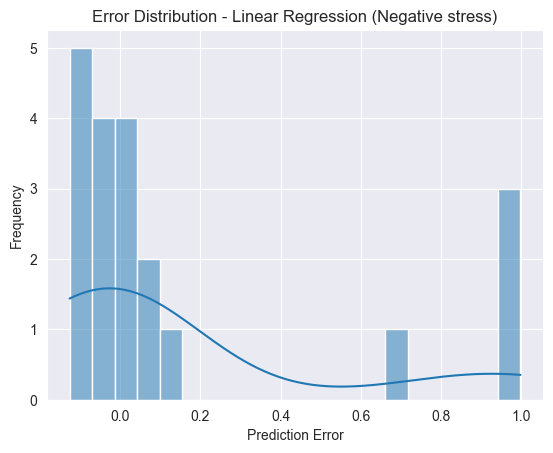


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
38 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.159
  Mean Absolute Error (MAE): 0.193
  R² Score: 0.004
  Explained Variance Score: 0.162


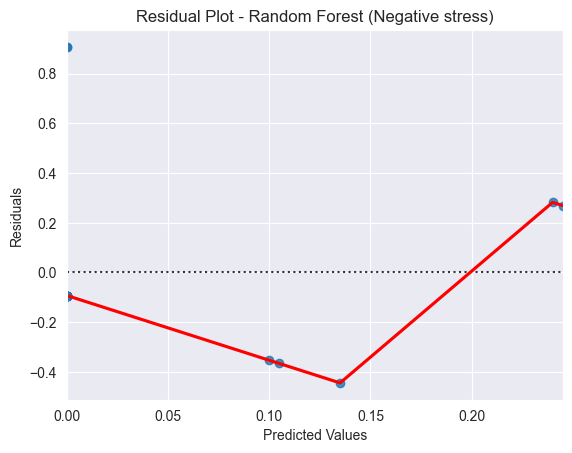

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


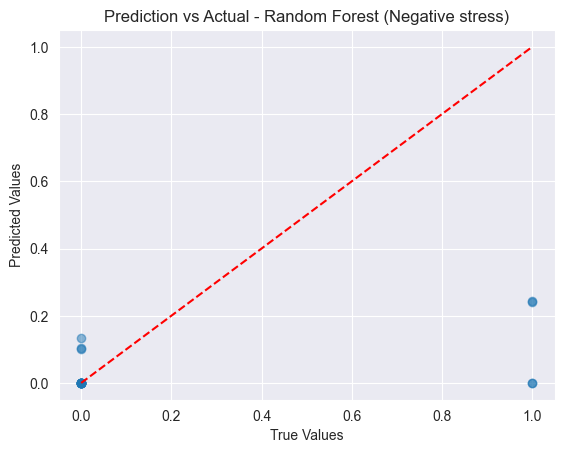

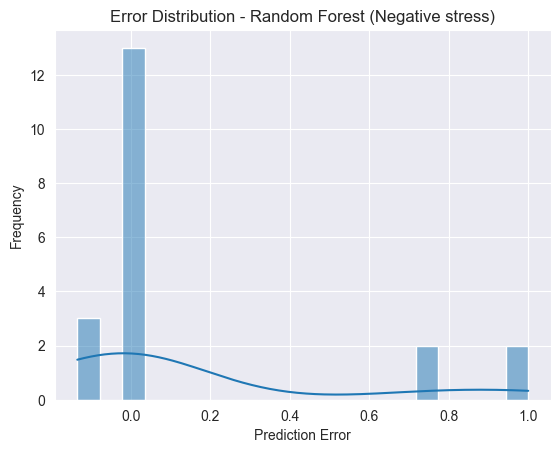


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.01}
Lasso Regression Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.186
  Mean Absolute Error (MAE): 0.215
  R² Score: -0.161
  Explained Variance Score: 0.032


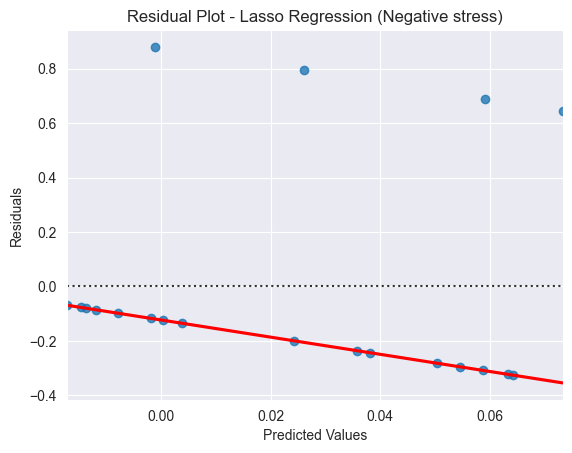

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


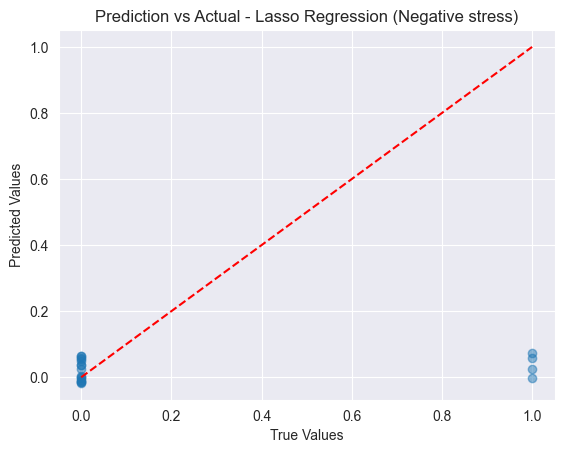

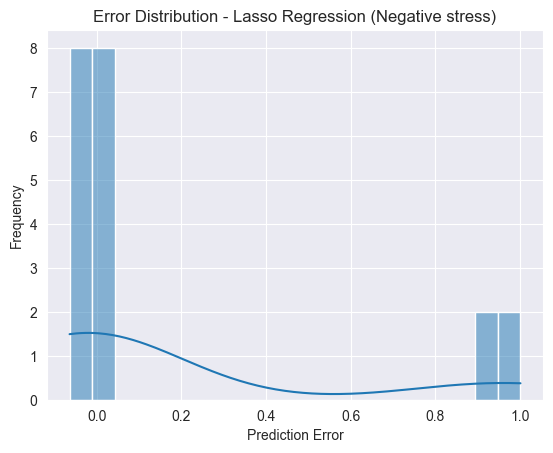


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 100}
Ridge Regression Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.184
  Mean Absolute Error (MAE): 0.217
  R² Score: -0.150
  Explained Variance Score: 0.049


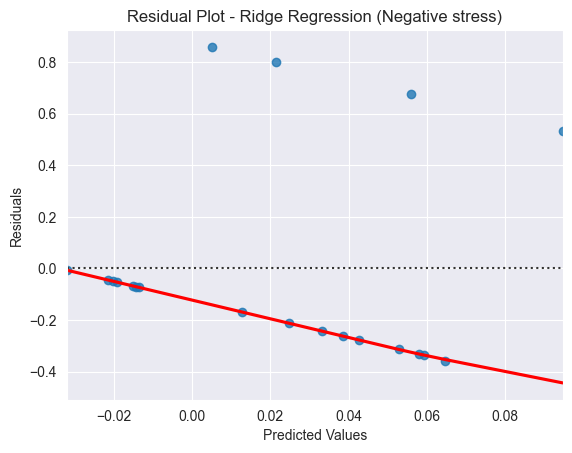

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


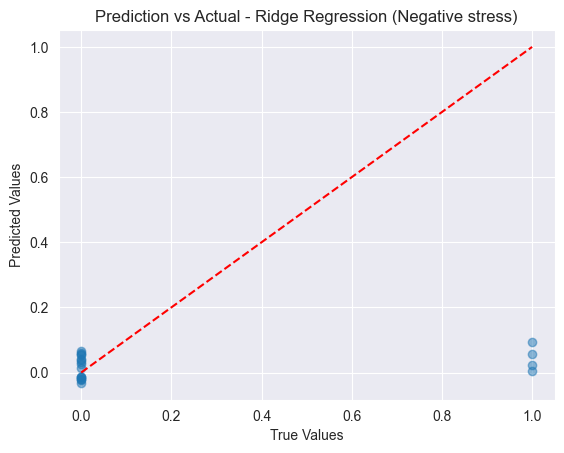

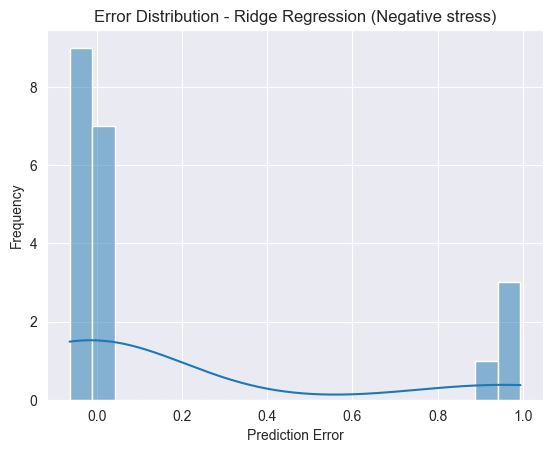


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.1}
Support Vector Regressor Performance Metrics for Negative stress:
  Mean Squared Error (MSE): 0.177
  Mean Absolute Error (MAE): 0.222
  R² Score: -0.106
  Explained Variance Score: 0.036


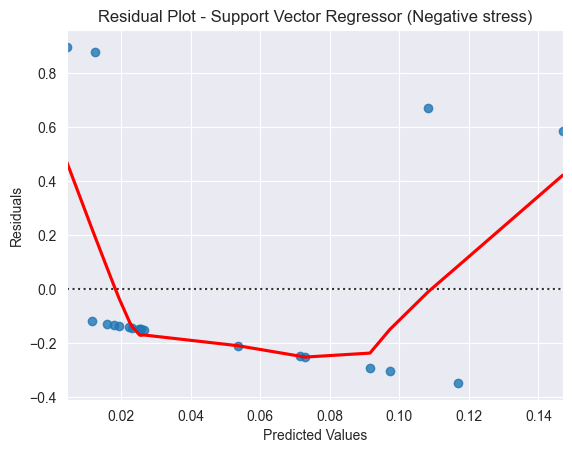

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


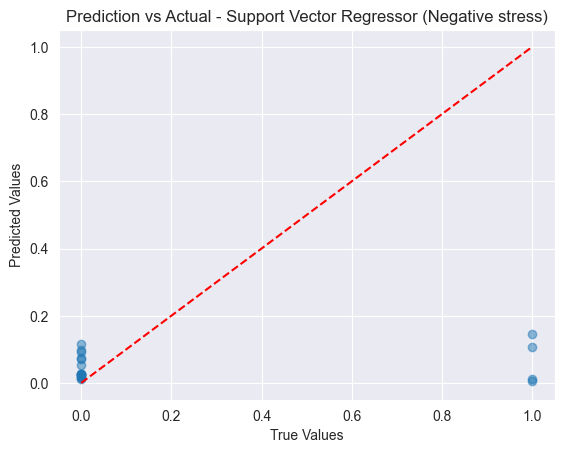

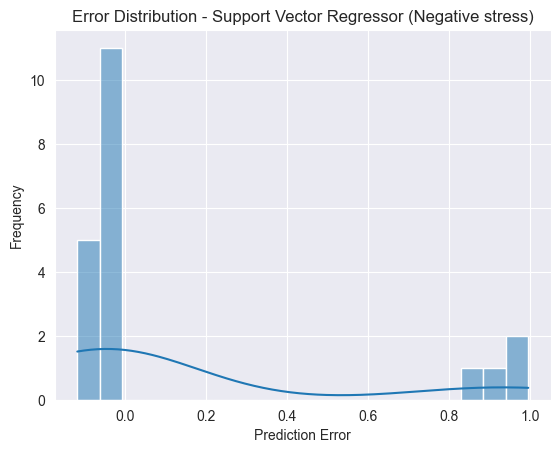


Processing target: Positive Binary

Processing model: Linear Regression
Linear Regression Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.230
  Mean Absolute Error (MAE): 0.391
  R² Score: 0.070
  Explained Variance Score: 0.071


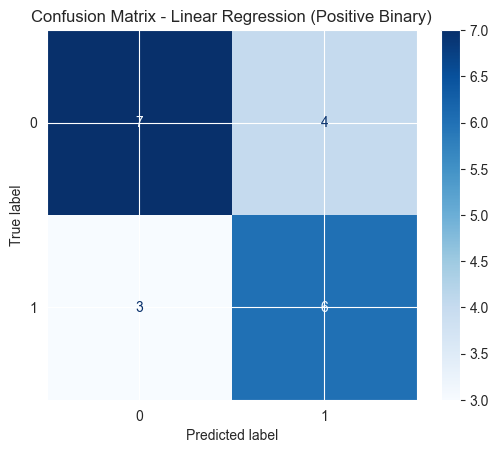

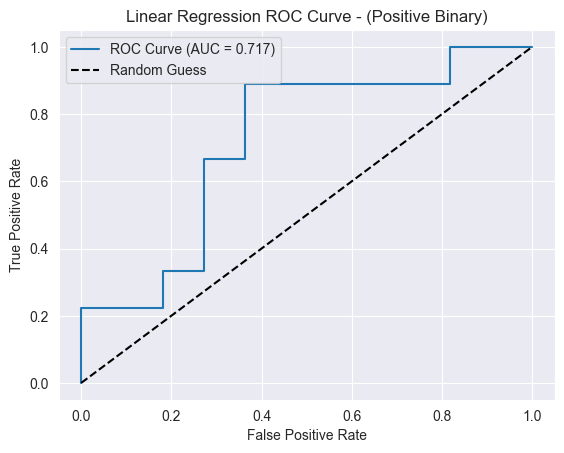


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.152
  Mean Absolute Error (MAE): 0.267
  R² Score: 0.386
  Explained Variance Score: 0.396


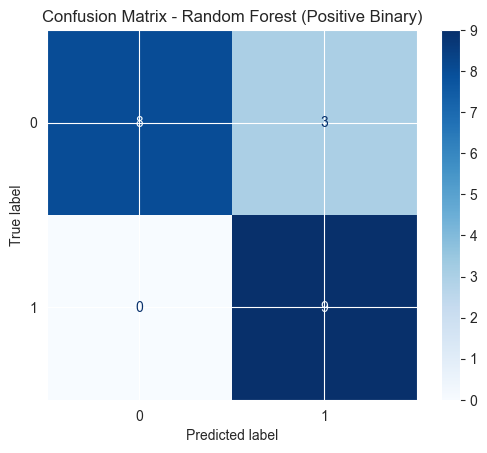

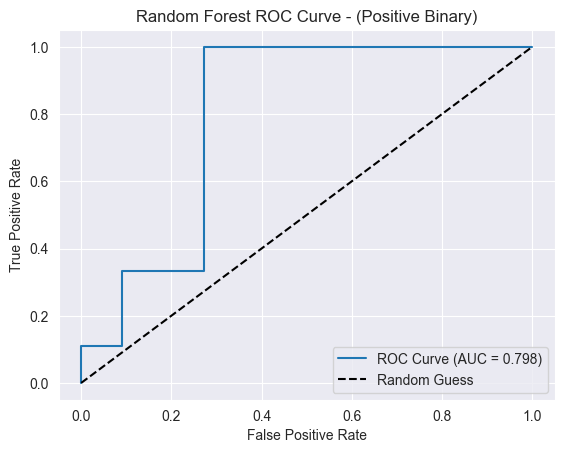


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.01}
Lasso Regression Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.171
  Mean Absolute Error (MAE): 0.328
  R² Score: 0.309
  Explained Variance Score: 0.309


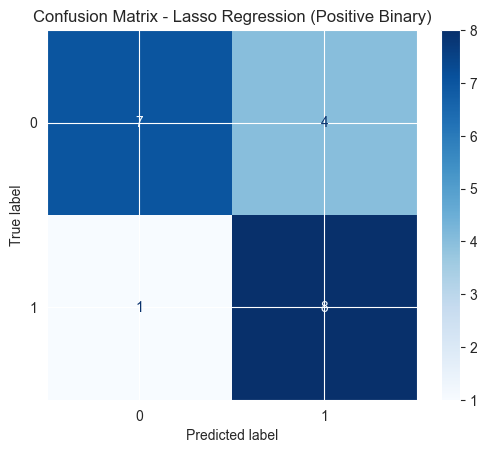

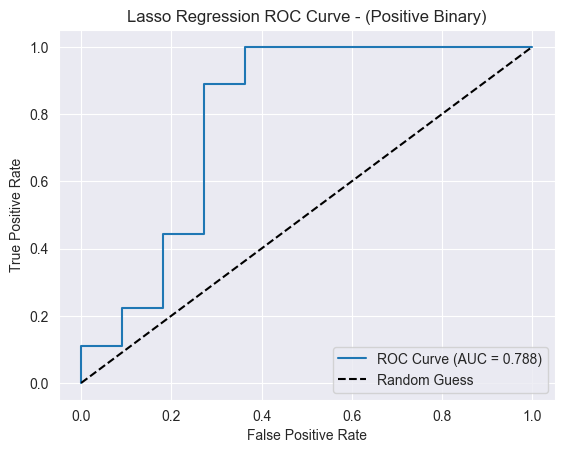


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 10}
Ridge Regression Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.177
  Mean Absolute Error (MAE): 0.336
  R² Score: 0.286
  Explained Variance Score: 0.286


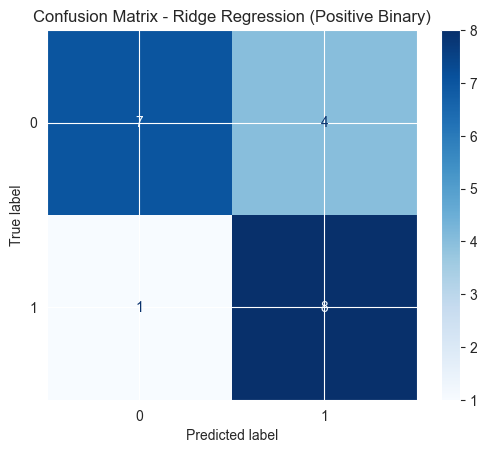

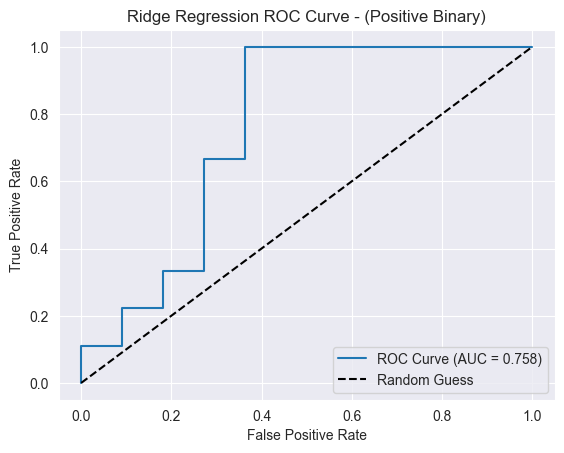


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.2}
Support Vector Regressor Performance Metrics for Positive Binary:
  Mean Squared Error (MSE): 0.173
  Mean Absolute Error (MAE): 0.287
  R² Score: 0.300
  Explained Variance Score: 0.311


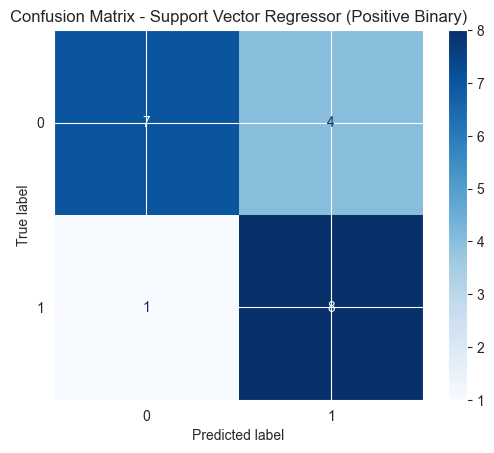

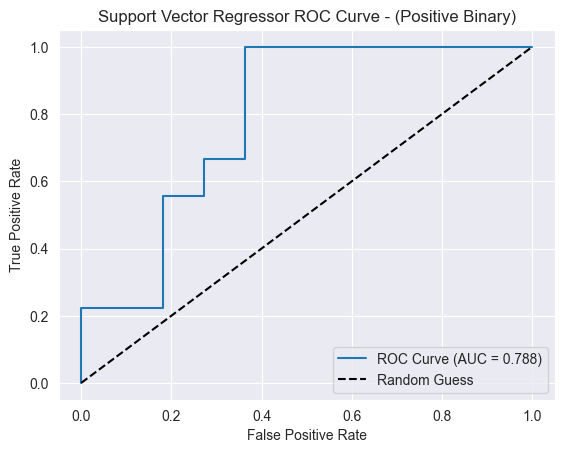


Processing target: Negative Binary

Processing model: Linear Regression
Linear Regression Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.172
  Mean Absolute Error (MAE): 0.232
  R² Score: -0.074
  Explained Variance Score: 0.088


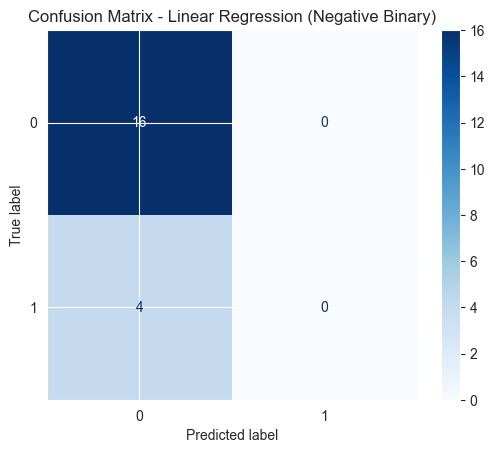

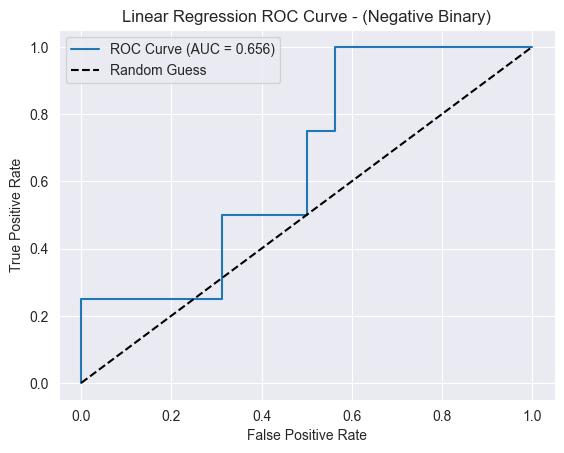


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.159
  Mean Absolute Error (MAE): 0.193
  R² Score: 0.004
  Explained Variance Score: 0.162


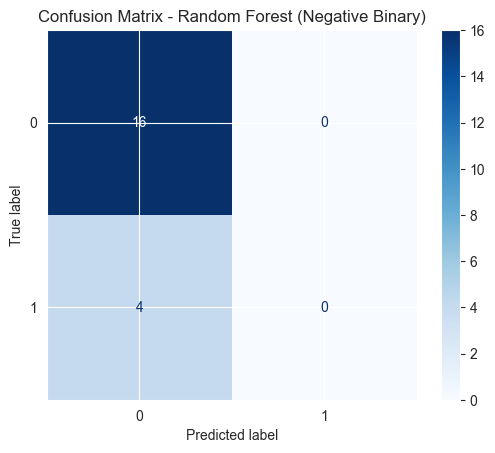

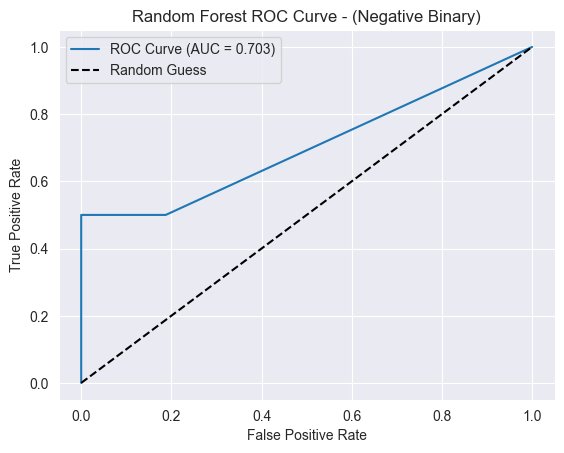


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.01}
Lasso Regression Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.186
  Mean Absolute Error (MAE): 0.215
  R² Score: -0.161
  Explained Variance Score: 0.032


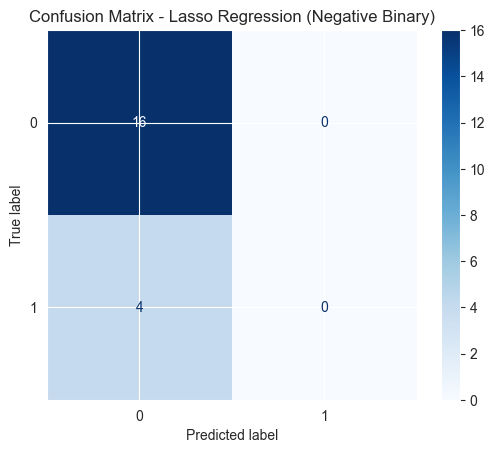

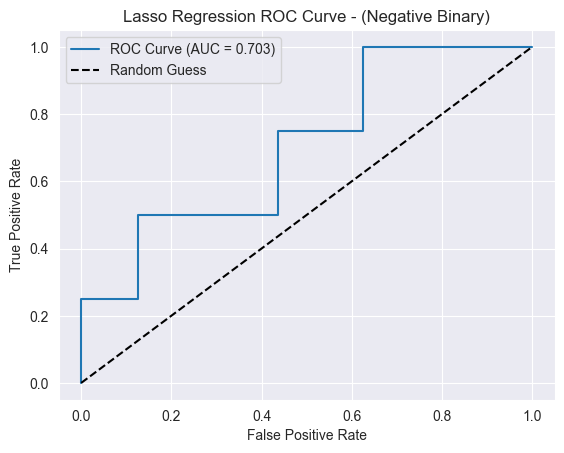


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 100}
Ridge Regression Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.184
  Mean Absolute Error (MAE): 0.217
  R² Score: -0.150
  Explained Variance Score: 0.049


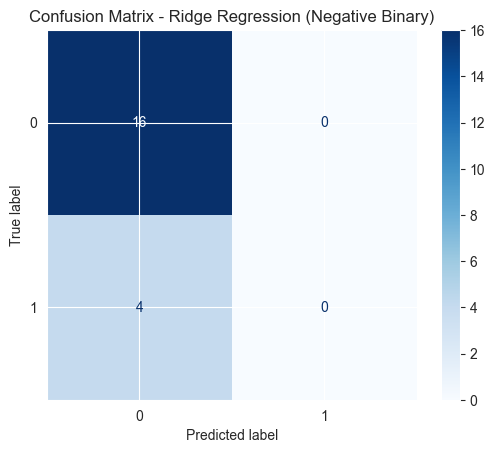

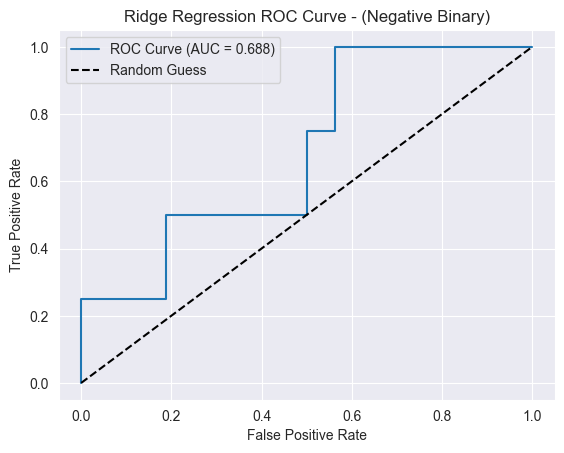


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.1}
Support Vector Regressor Performance Metrics for Negative Binary:
  Mean Squared Error (MSE): 0.177
  Mean Absolute Error (MAE): 0.222
  R² Score: -0.106
  Explained Variance Score: 0.036


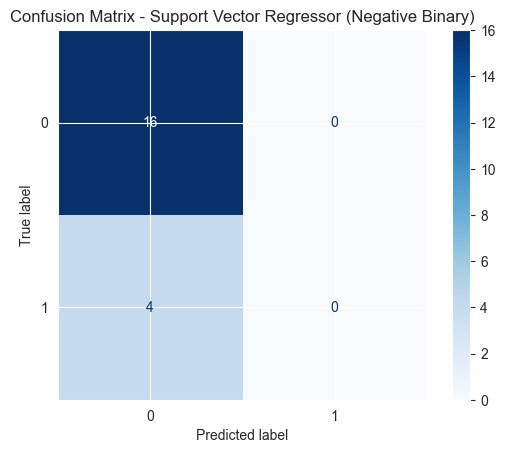

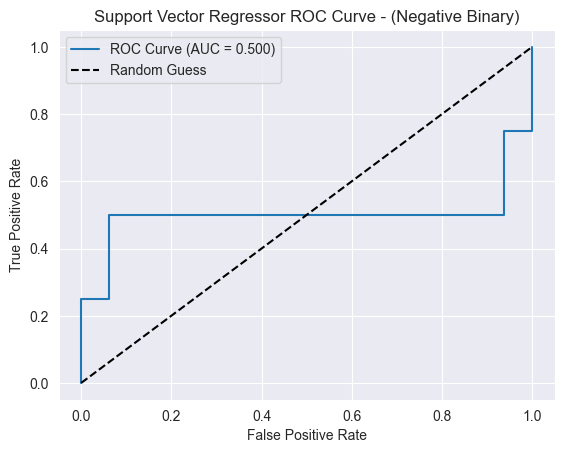


Processing target: Total Stress

Processing model: Linear Regression
Linear Regression Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 1.029
  Mean Absolute Error (MAE): 0.707
  R² Score: -0.110
  Explained Variance Score: -0.108


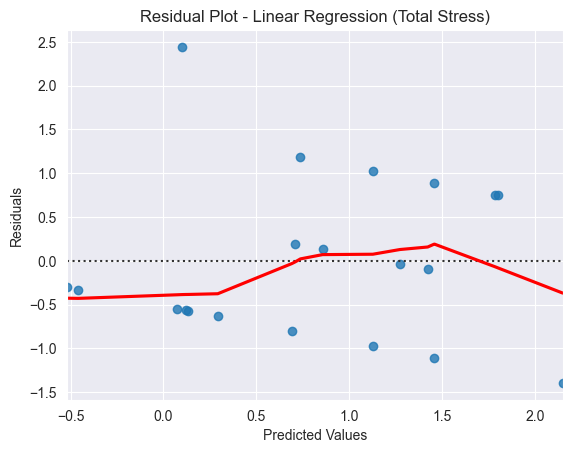

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


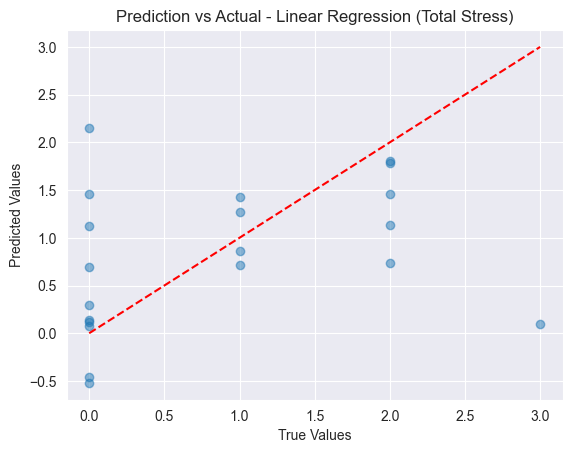

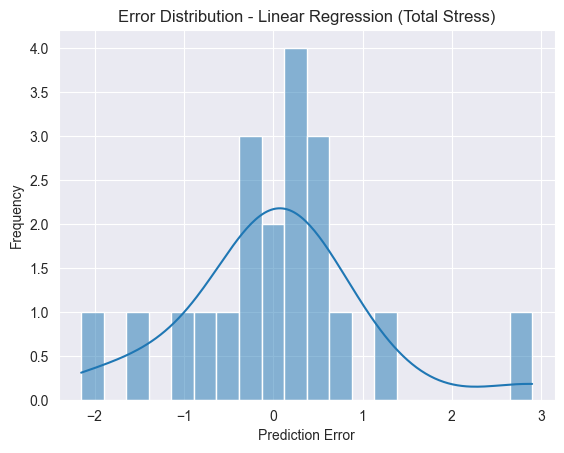


Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666,

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Random Forest Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.838
  Mean Absolute Error (MAE): 0.612
  R² Score: 0.096
  Explained Variance Score: 0.097


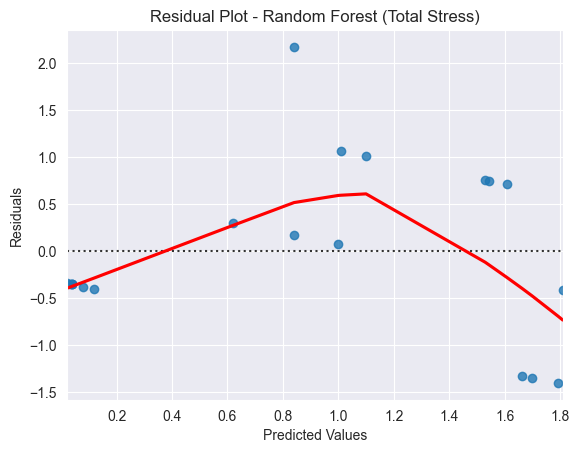

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


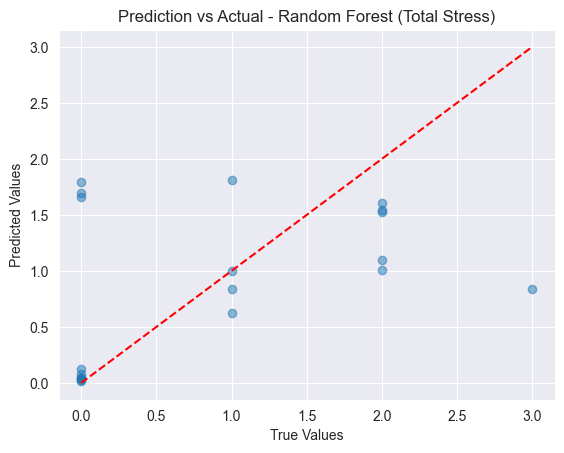

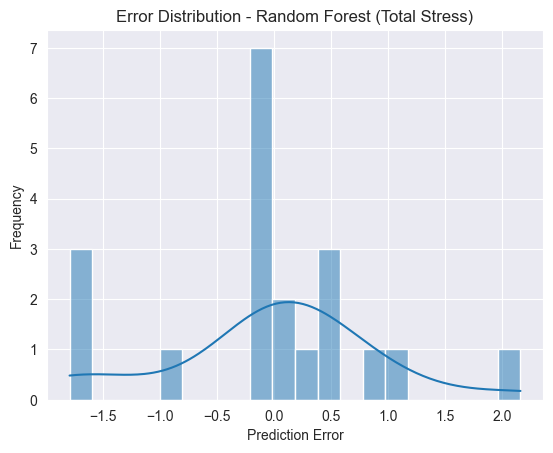


Processing model: Lasso Regression
Best parameters for Lasso Regression: {'alpha': 0.1}
Lasso Regression Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.738
  Mean Absolute Error (MAE): 0.615
  R² Score: 0.204
  Explained Variance Score: 0.211


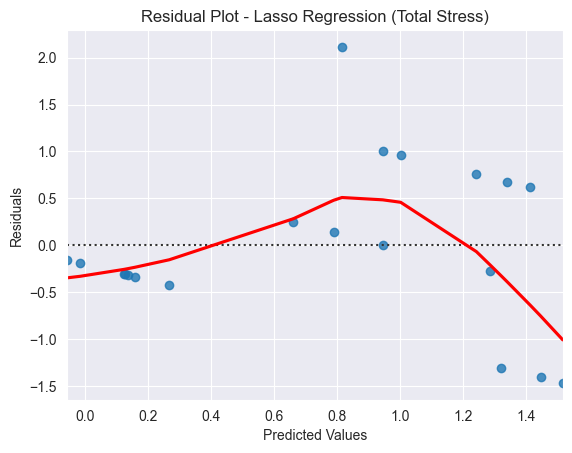

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


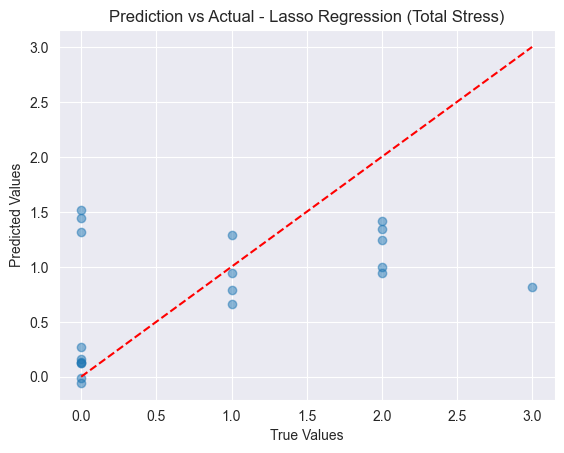

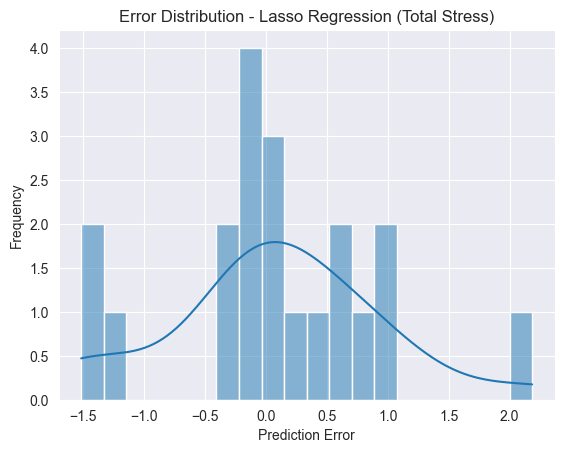


Processing model: Ridge Regression
Best parameters for Ridge Regression: {'alpha': 10}
Ridge Regression Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.769
  Mean Absolute Error (MAE): 0.597
  R² Score: 0.171
  Explained Variance Score: 0.176


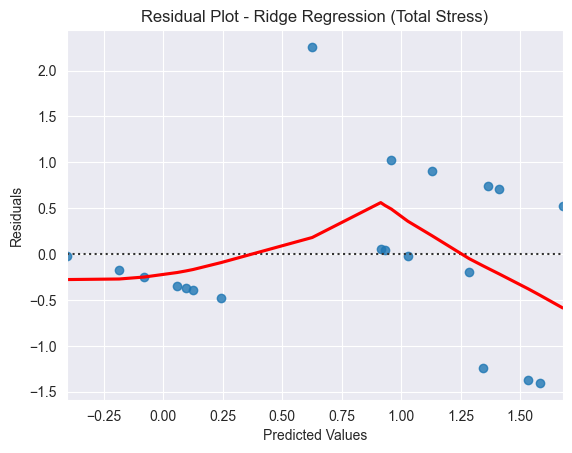

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


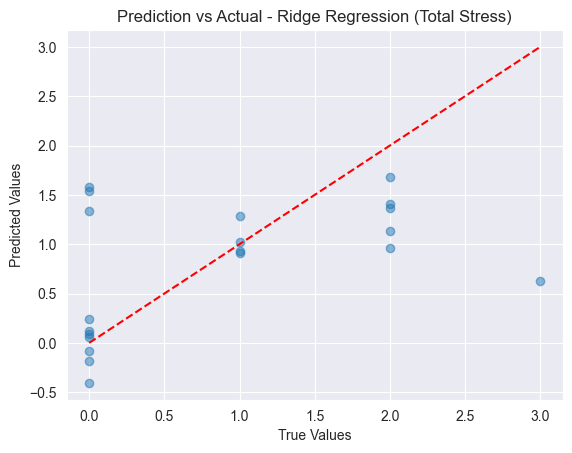

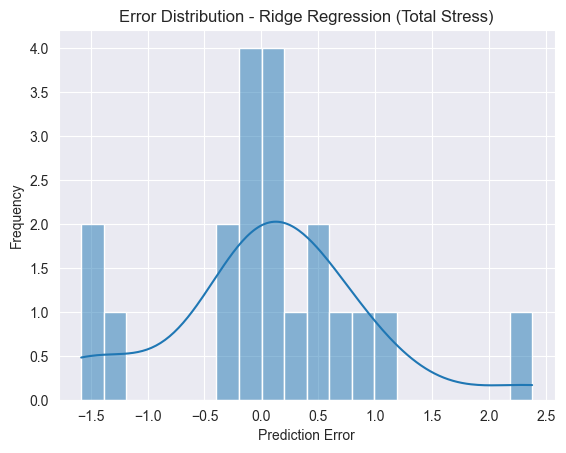


Processing model: Support Vector Regressor
Best parameters for Support Vector Regressor: {'C': 1, 'epsilon': 0.2}
Support Vector Regressor Performance Metrics for Total Stress:
  Mean Squared Error (MSE): 0.864
  Mean Absolute Error (MAE): 0.561
  R² Score: 0.068
  Explained Variance Score: 0.072


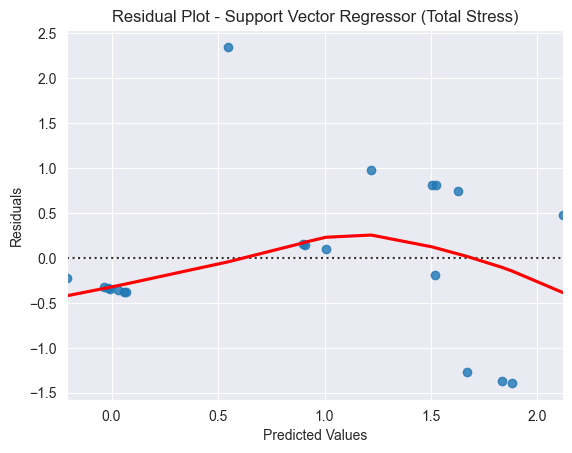

C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\4244924195.py:134: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


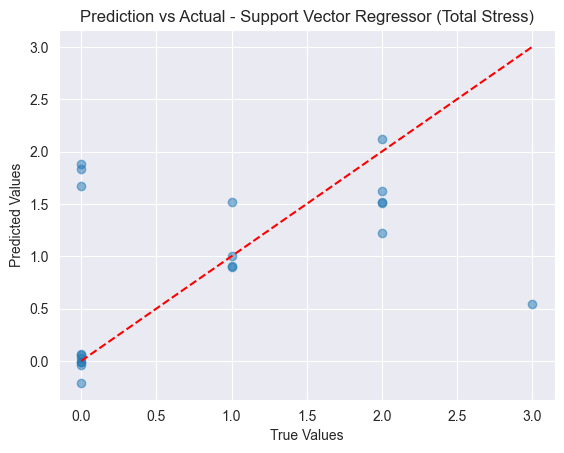

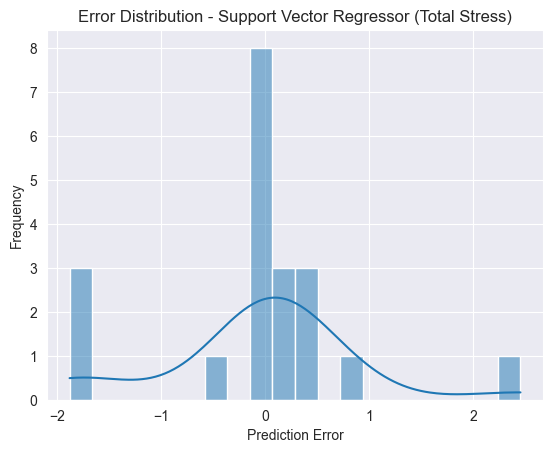

In [ ]:
# Include only the most important features based on correlation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)


# Define the features (X) and targets (y)
X = merged_df[[
    "median_nni", "mean_nni", "mean_hr", "pnni_20", "nni_20", "min_hr",
    "nni_50", "pnni_50", "vlf", "cvi", "sdsd", "sd1", "rmssd",
    "hfnu", "lfnu", "lf_hf_ratio", "range_nni", "sdnn", "sd2"
]]
y_targets = {
    'Positive stress': merged_df['Positive stress'],
    'Negative stress': merged_df['Negative stress'],
    'Positive Binary': merged_df['Positive Binary'],
    'Negative Binary': merged_df['Negative Binary'],
    'Total Stress': merged_df['Total Stress']
}

# Standardize X (already scaled)
X_scaled = X
# Define models and parameters
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Support Vector Regressor': SVR()
}

param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20]
    },
    'Lasso Regression': {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    },
    'Ridge Regression': {
        'alpha': [0.1, 1, 10, 100]
    },
    'Support Vector Regressor': {
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.5]
    }
}

# Define target variables
target_variables = [
    ('Positive stress', merged_df['Positive stress']),
    ('Negative stress', merged_df['Negative stress']),
    ('Positive Binary', merged_df['Positive Binary']),
    ('Negative Binary', merged_df['Negative Binary']),
    ('Total Stress', merged_df['Total Stress'])
]


# Iterate through targets and models
for target_name, target in target_variables:
    print(f"\nProcessing target: {target_name}")
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

    for model_name, model in models.items():
        print(f"\nProcessing model: {model_name}")
        param_grid = param_grids[model_name]

        # Grid Search
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        else:
            model.fit(X_train, y_train)

        # Predictions and metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        print(f"{model_name} Performance Metrics for {target_name}:")
        print(f"  Mean Squared Error (MSE): {mse:.3f}")
        print(f"  Mean Absolute Error (MAE): {mae:.3f}")
        print(f"  R² Score: {r2:.3f}")
        print(f"  Explained Variance Score: {evs:.3f}")

        # Visualizations for binary targets
        if target_name in ['Positive Binary', 'Negative Binary']:
            binary_predictions = (y_pred >= 0.5).astype(int)
            cm = confusion_matrix(y_test, binary_predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            disp.plot(cmap='Blues')
            plt.title(f'Confusion Matrix - {model_name} ({target_name})')
            plt.show()

            # ROC Curve
            roc_auc = roc_auc_score(y_test, y_pred)
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.title(f'{model_name} ROC Curve - ({target_name})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.show()

        # Visualizations for continuous targets
        else:
            # Residual Plot
            sns.residplot(x=y_pred, y=(y_test - y_pred), lowess=True, line_kws={'color': 'red'})
            plt.title(f'Residual Plot - {model_name} ({target_name})')
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.show()

            # Prediction vs True Values Scatter Plot
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')
            plt.title(f'Prediction vs Actual - {model_name} ({target_name})')
            plt.xlabel('True Values')
            plt.ylabel('Predicted Values')
            plt.show()

            # Error Distribution
            sns.histplot((y_test - y_pred), kde=True, bins=20)
            plt.title(f'Error Distribution - {model_name} ({target_name})')
            plt.xlabel('Prediction Error')
            plt.ylabel('Frequency')
            plt.show()


Got worse results with including only the TOP features

Results are based on this below!!!

In [ ]:
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)


# Create directory for saving plots
output_dir = "model_results"
os.makedirs(output_dir, exist_ok=True)

# Prepare dataset for results
results = []

# Define features and target variables
X = merged_df[['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf',
               'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20',
               'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni',
               'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'sd1', 'sd2',
               'ratio_sd2_sd1', 'csi', 'cvi', 'Modified_csi']]

y_targets = {
    'Positive stress': merged_df['Positive stress'],
    'Negative stress': merged_df['Negative stress'],
    'Positive Binary': merged_df['Positive Binary'],
    'Negative Binary': merged_df['Negative Binary'],
    'Total Stress': merged_df['Total Stress']
}

# Define models and hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Support Vector Regressor': SVR()
}

param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20]
    },
    'Lasso Regression': {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    },
    'Ridge Regression': {
        'alpha': [0.1, 1, 10, 100]
    },
    'Support Vector Regressor': {
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.5]
    }
}

# Process each target
for target_name, target in y_targets.items():
    print(f"\nProcessing target: {target_name}")
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

    for model_name, model in models.items():
        print(f"\nProcessing model: {model_name}")
        param_grid = param_grids.get(model_name, {})

        # Grid Search
        if param_grid:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            model.fit(X_train, y_train)
            best_params = {}

        # Predictions and metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)

        # Save metrics
        results.append({
            'Target': target_name,
            'Model': model_name,
            'MSE': mse,
            'MAE': mae,
            'R²': r2,
            'EVS': evs,
            'Best Params': best_params
        })

        # Save plots
        base_filename = f"{output_dir}/{model_name}_{target_name.replace(' ', '_')}"

        # Binary classification metrics and plots
        if target_name in ['Positive Binary', 'Negative Binary']:
            binary_predictions = (y_pred >= 0.5).astype(int)
            cm = confusion_matrix(y_test, binary_predictions)

            # Confusion Matrix
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            disp.plot(cmap='Blues')
            plt.title(f'Confusion Matrix - {model_name} ({target_name})')
            plt.savefig(f"{base_filename}_confusion_matrix.png")
            plt.close()

            # ROC Curve
            roc_auc = roc_auc_score(y_test, y_pred)
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.title(f'ROC Curve - {model_name} ({target_name})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.savefig(f"{base_filename}_roc_curve.png")
            plt.close()

        # Continuous target plots
        else:
            # Residual Plot
            sns.residplot(x=y_pred, y=(y_test - y_pred), lowess=True, line_kws={'color': 'red'})
            plt.title(f'Residual Plot - {model_name} ({target_name})')
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.savefig(f"{base_filename}_residuals.png")
            plt.close()

            # Prediction vs True Values Scatter Plot
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')
            plt.title(f'Prediction vs Actual - {model_name} ({target_name})')
            plt.xlabel('True Values')
            plt.ylabel('Predicted Values')
            plt.savefig(f"{base_filename}_prediction_vs_actual.png")
            plt.close()

            # Error Distribution
            sns.histplot((y_test - y_pred), kde=True, bins=20)
            plt.title(f'Error Distribution - {model_name} ({target_name})')
            plt.xlabel('Prediction Error')
            plt.ylabel('Frequency')
            plt.savefig(f"{base_filename}_error_distribution.png")
            plt.close()

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f"{output_dir}/model_performance_metrics.csv", index=False)
print("All results and plots saved successfully!")



Processing target: Positive stress

Processing model: Linear Regression


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666,


Processing model: Lasso Regression


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Ridge Regression


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Support Vector Regressor


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing target: Negative stress

Processing model: Linear Regression


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666


Processing model: Lasso Regression


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Ridge Regression


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Support Vector Regressor


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing target: Positive Binary

Processing model: Linear Regression

Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666


Processing model: Lasso Regression

Processing model: Ridge Regression

Processing model: Support Vector Regressor

Processing target: Negative Binary

Processing model: Linear Regression

Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666


Processing model: Lasso Regression

Processing model: Ridge Regression

Processing model: Support Vector Regressor

Processing target: Total Stress

Processing model: Linear Regression


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Random Forest


C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Dominik\PycharmProjects\Sport_Lab\SportLab\lib\site-packages\sklearn\base.py", line 666


Processing model: Lasso Regression


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Ridge Regression


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')



Processing model: Support Vector Regressor


C:\Users\Dominik\AppData\Local\Temp\ipykernel_21044\506784326.py:148: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


All results and plots saved successfully!
